In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

# EDA

- 데이터 로드 : 아래 target 외 row는 삭제하고 진행 
  - 데이터 수 : 2,925,492 -> 1,879,637 
  - 우량 대출 : Fully Paid(완납) = 1
  - 불량 대출 : Charged Off(상각), Default(부도), Late - Late (31-120 days),Late (16-30 days)(연체) = 0

In [20]:
df = pd.read_csv("data/lending_club_data.csv").iloc[:,2:]

FileNotFoundError: [Errno 2] No such file or directory: 'data/lending_club_data.csv'

In [ ]:
df.loan_status.value_counts()

loan_status
Fully Paid                                             1497783
Current                                                1031016
Charged Off                                             362548
Late (31-120 days)                                       16154
In Grace Period                                          10028
Late (16-30 days)                                         2719
Issued                                                    2062
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                    433
Name: count, dtype: int64

In [ ]:
# Late 상태 통합: loan_status 값을 변경하여 Late로 통합
df['loan_status'] = df['loan_status'].replace(
    {'Late (31-120 days)': 'Late', 'Late (16-30 days)': 'Late'}
)

In [ ]:

# loan_status 값을 이진(binary) 값으로 매핑
loan_status_mapping = {
    'Fully Paid': 1,
    'Charged Off': 0,
    'Default': 0,
    'Late': 0,  # Late 상태를 통합
    # 분석에서 제외할 경우 None으로 설정
    'Current': None,
    'In Grace Period': None,
    'Issued': None,
    'Does not meet the credit policy. Status:Fully Paid': None,
    'Does not meet the credit policy. Status:Charged Off': None
}

In [ ]:

# loan_status 열에 매핑 적용
df['loan_status_binary'] = df['loan_status'].map(loan_status_mapping)

# 결측값(NaN)이 있는 행 제거
df = df.dropna(subset=['loan_status_binary'])

# loan_status_binary를 정수형(int)으로 변환
df['loan_status_binary'] = df['loan_status_binary'].astype(int)

# 기존 loan_status 열 삭제
df.drop('loan_status', axis=1, inplace=True)

In [ ]:
len(df)

1879637

- LightGBM 오류 방지 (특수문자 제거)

In [ ]:
def clean_column_names(df):
    df.columns = [re.sub(r'[^A-Za-z0-9_]+', '_', col) for col in df.columns]
    return df

In [ ]:
df = clean_column_names(df)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1879637 entries, 0 to 2925492
Columns: 140 entries, loan_amnt to loan_status_binary
dtypes: float64(106), int32(1), object(33)
memory usage: 2.0+ GB


In [ ]:
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,loan_status_binary
0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,1
1,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,0
2,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,1
3,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,1
4,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,University Medical Group,1 year,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,1


- 결측치 높은 컬럼(결측값 비율 10% 이상 컬럼) 제거
- 결측치 제거: 결측값이 존재하는 데이터(row) 제거

In [ ]:
# # isnull : dataframe의 각 셀에 대해 결측치(T/F) 판단
df.isnull().sum() # 컬럼 마다 결측치 개수 확인용

loan_amnt                                           0
funded_amnt                                         0
funded_amnt_inv                                     0
term                                                0
int_rate                                            0
                                               ...   
orig_projected_additional_accrued_interest    1853381
hardship_payoff_balance_amount                1850545
hardship_last_payment_amount                  1850545
debt_settlement_flag                                0
loan_status_binary                                  0
Length: 140, dtype: int64

In [ ]:
missing_ratio = df.isnull().mean().sort_values(ascending = False)

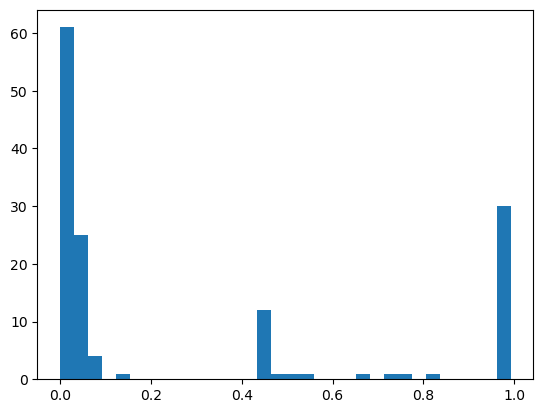

In [ ]:
# mssing ratio의 빈도수 시각화 - mission ratio가 10% 이내인 것들만 사용
# 가로 축 : 결측치 비율, 세로 축 : 해당하는 변수 개수
plt.hist(missing_ratio, bins = 32)
plt.show()

In [ ]:
missing_ratio = df.isnull().mean()
missing_0_10 = missing_ratio[(missing_ratio >= 0) & (missing_ratio <= 0.1)].index.tolist()

print('\n 결측치 0~10% 컬럼:')
print(missing_0_10)


 결측치 0~10% 컬럼:
['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'pymnt_plan', 'url', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'm

In [ ]:
len(missing_0_10)

90

In [ ]:
# 결측치 10% 이내인 column만 사용
df = df.loc[:,missing_0_10]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1879637 entries, 0 to 2925492
Data columns (total 90 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   loan_amnt                   float64
 1   funded_amnt                 float64
 2   funded_amnt_inv             float64
 3   term                        object 
 4   int_rate                    object 
 5   installment                 float64
 6   grade                       object 
 7   sub_grade                   object 
 8   emp_title                   object 
 9   emp_length                  object 
 10  home_ownership              object 
 11  annual_inc                  float64
 12  verification_status         object 
 13  issue_d                     object 
 14  pymnt_plan                  object 
 15  url                         object 
 16  purpose                     object 
 17  title                       object 
 18  zip_code                    object 
 19  addr_state                

In [ ]:
df.shape

(1879637, 90)

In [ ]:
# NaN 있는 행을 원본 df에서 직접 삭제
# df.dropna(inplace = True)

- 다른 변수에 종속인 변수(상관계수)

In [ ]:
# 상관계수 기준으로 상관 높은 변수 select 함수
def select_highly_correlated_features(df, method='pearson', threshold=0.8):
    corr_matrix = df.select_dtypes(include =['int64','float64']).corr(method=method)
    # upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    np.fill_diagonal(corr_matrix.values, np.nan)
    to_drop = [column for column in corr_matrix.columns if any(abs(corr_matrix[column]) > threshold)]
    return to_drop

In [ ]:
high_corr_col = select_highly_correlated_features(df, method='pearson', threshold=0.9)

In [ ]:
high_corr_col

['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'installment',
 'fico_range_low',
 'fico_range_high',
 'open_acc',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'recoveries',
 'collection_recovery_fee',
 'tot_cur_bal',
 'num_actv_rev_tl',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'tot_hi_cred_lim']

In [ ]:
df.loc[:,high_corr_col].corr()

,loan_amnt,funded_amnt,funded_amnt_inv,installment,fico_range_low,fico_range_high,open_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,recoveries,collection_recovery_fee,tot_cur_bal,num_actv_rev_tl,num_rev_tl_bal_gt_0,num_sats,tot_hi_cred_lim
loan_amnt,1.000000,0.999704,0.999031,0.951254,0.100046,0.100045,0.181698,0.078482,0.078485,0.853660,0.853342,0.793866,0.192974,0.188026,0.310150,0.150466,0.149736,0.179487,0.332605
funded_amnt,0.999704,1.000000,0.999388,0.951688,0.099494,0.099494,0.181908,0.078559,0.078562,0.853829,0.853566,0.794084,0.193084,0.188184,0.310150,0.150466,0.149736,0.179487,0.332605
funded_amnt_inv,0.999031,0.999388,1.000000,0.950981,0.098882,0.098881,0.182170,0.078683,0.078686,0.853352,0.854086,0.793653,0.193025,0.188093,0.310173,0.150431,0.149701,0.179474,0.332632
installment,0.951254,0.951688,0.950981,1.000000,0.048175,0.048175,0.172111,0.066827,0.066828,0.811794,0.811453,0.767654,0.174735,0.170388,0.279382,0.158293,0.157290,0.169187,0.299350
fico_range_low,0.100046,0.099494,0.098882,0.048175,1.000000,1.000000,0.017781,0.007157,0.007156,0.084549,0.084029,0.138584,-0.057398,-0.056163,0.124811,-0.194317,-0.193528,0.029183,0.190281
fico_range_high,0.100045,0.099494,0.098881,0.048175,1.000000,1.000000,0.017780,0.007157,0.007156,0.084548,0.084028,0.138583,-0.057397,-0.056163,0.124811,-0.194317,-0.193528,0.029182,0.190282
open_acc,0.181698,0.181908,0.182170,0.172111,0.017781,0.017780,1.000000,0.008107,0.008107,0.154840,0.155135,0.145516,0.040906,0.041402,0.249476,0.664815,0.667093,0.998884,0.289376
out_prncp,0.078482,0.078559,0.078683,0.066827,0.007157,0.007157,0.008107,1.000000,0.999999,-0.042816,-0.042692,-0.059981,-0.020623,-0.019915,0.007279,0.008160,0.008218,0.007532,0.010163
out_prncp_inv,0.078485,0.078562,0.078686,0.066828,0.007156,0.007156,0.008107,0.999999,1.000000,-0.042814,-0.042689,-0.059979,-0.020622,-0.019914,0.007281,0.008160,0.008218,0.007532,0.010165
total_pymnt,0.853660,0.853829,0.853352,0.811794,0.084549,0.084548,0.154840,-0.042816,-0.042814,1.000000,0.999522,0.964948,-0.048826,-0.042725,0.293706,0.133090,0.134292,0.153362,0.311372


<Axes: >

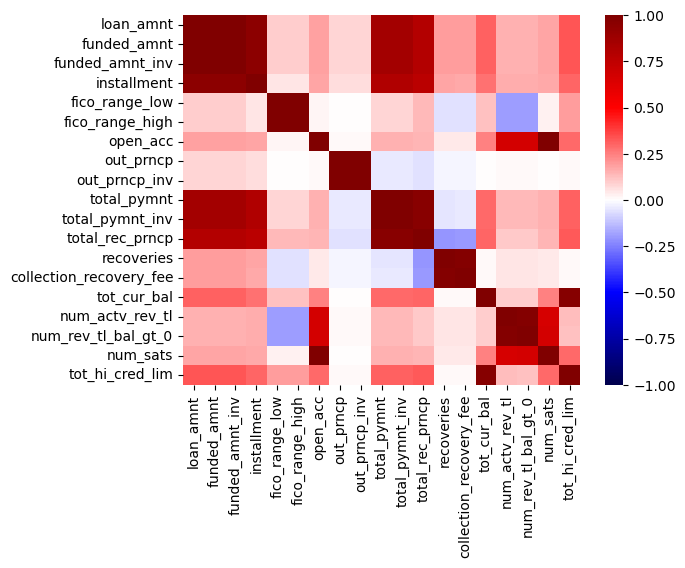

In [ ]:
# 여기서 보고 적당한 변수 선택
# ex) loan_amnt, funded_amnt, funded_amnt_inv, installment 가 높은 값을 가지기 때문에 이 중 loan_amnt 변수를 제외하고 삭제
sns.heatmap(df.loc[:,high_corr_col].corr(), vmin=-1, vmax=1, cmap='seismic')

In [ ]:
drop_col = ['loan_amnt', 'funded_amnt_inv', 'installment', 'fico_range_low', 'out_prncp_inv', 'total_pymnt_inv', 'total_rec_prncp', 'num_sats', 
            'collection_recovery_fee', 'tot_hi_cred_lim', 'num_op_rev_tl']
df.drop(drop_col, axis = 1, inplace = True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1879637 entries, 0 to 2925492
Data columns (total 79 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   funded_amnt                 float64
 1   term                        object 
 2   int_rate                    object 
 3   grade                       object 
 4   sub_grade                   object 
 5   emp_title                   object 
 6   emp_length                  object 
 7   home_ownership              object 
 8   annual_inc                  float64
 9   verification_status         object 
 10  issue_d                     object 
 11  pymnt_plan                  object 
 12  url                         object 
 13  purpose                     object 
 14  title                       object 
 15  zip_code                    object 
 16  addr_state                  object 
 17  dti                         float64
 18  delinq_2yrs                 float64
 19  earliest_cr_line          

In [ ]:
df.head()

,funded_amnt,term,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag,loan_status_binary
0,5000.0,36 months,10.65%,B,B2,NaN,10+ years,RENT,24000.0,Verified,...,NaN,NaN,0.0,0.0,NaN,NaN,NaN,N,N,1
1,2500.0,60 months,15.27%,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,...,NaN,NaN,0.0,0.0,NaN,NaN,NaN,N,N,0
2,2400.0,36 months,15.96%,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,...,NaN,NaN,0.0,0.0,NaN,NaN,NaN,N,N,1
3,10000.0,36 months,13.49%,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,...,NaN,NaN,0.0,0.0,NaN,NaN,NaN,N,N,1
4,3000.0,60 months,12.69%,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,...,NaN,NaN,0.0,0.0,NaN,NaN,NaN,N,N,1


In [ ]:
df.columns

Index(['funded_amnt', 'term', 'int_rate', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'pymnt_plan', 'url', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'total_pymnt', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'last_fico_range_high', 'last_fico_range_low',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
 

In [ ]:
df.select_dtypes(include = 'object')

,term,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,pymnt_plan,...,zip_code,addr_state,earliest_cr_line,revol_util,initial_list_status,last_pymnt_d,last_credit_pull_d,application_type,hardship_flag,debt_settlement_flag
0,36 months,10.65%,B,B2,NaN,10+ years,RENT,Verified,Dec-2011,n,...,860xx,AZ,Jan-1985,83.7%,f,Jan-2015,May-2020,Individual,N,N
1,60 months,15.27%,C,C4,Ryder,< 1 year,RENT,Source Verified,Dec-2011,n,...,309xx,GA,Apr-1999,9.4%,f,Apr-2013,Oct-2016,Individual,N,N
2,36 months,15.96%,C,C5,NaN,10+ years,RENT,Not Verified,Dec-2011,n,...,606xx,IL,Nov-2001,98.5%,f,Jun-2014,Jun-2017,Individual,N,N
3,36 months,13.49%,C,C1,AIR RESOURCES BOARD,10+ years,RENT,Source Verified,Dec-2011,n,...,917xx,CA,Feb-1996,21%,f,Jan-2015,Apr-2016,Individual,N,N
4,60 months,12.69%,B,B5,University Medical Group,1 year,RENT,Source Verified,Dec-2011,n,...,972xx,OR,Jan-1996,53.9%,f,Jan-2017,Apr-2018,Individual,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925488,60 months,23.99%,E,E2,Senior Escrow Officer,< 1 year,RENT,Source Verified,Apr-2017,n,...,801xx,CO,Apr-1995,24.9%,f,Mar-2018,May-2020,Individual,N,N
2925489,36 months,7.99%,A,A5,Rn,10+ years,MORTGAGE,Source Verified,Apr-2017,n,...,187xx,PA,Sep-1993,15.7%,w,Oct-2019,Oct-2019,Individual,N,N
2925490,36 months,16.99%,D,D1,Sales Associate,8 years,RENT,Not Verified,Apr-2017,n,...,220xx,VA,May-1993,47%,w,May-2019,Nov-2019,Individual,N,N
2925491,36 months,11.44%,B,B4,Contact input,5 years,RENT,Source Verified,Apr-2017,n,...,105xx,NY,May-1990,10.1%,w,Jan-2019,Mar-2020,Individual,N,N


In [ ]:
df.select_dtypes(include='object').columns.tolist()

['term',
 'int_rate',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'verification_status',
 'issue_d',
 'pymnt_plan',
 'url',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'earliest_cr_line',
 'revol_util',
 'initial_list_status',
 'last_pymnt_d',
 'last_credit_pull_d',
 'application_type',
 'hardship_flag',
 'debt_settlement_flag']

In [ ]:
# 문자열 데이터 공백제거
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype(str).str.strip()

In [ ]:
# % 포함된 값 → 숫자로 변환(예: '15.27%' → 15.27)
percent_cols = ["int_rate","revol_util"]
for col in percent_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).str.replace('%', '', regex=True).replace('', np.nan)
        df[col] = pd.to_numeric(df[col], errors='coerce')

In [ ]:
# 기간(term)"36 months" → 숫자로 변환
if "term" in df.columns:
    df["term"] = df["term"].astype(str).str.replace(' months', '', regex=True)
    df["term"] = pd.to_numeric(df["term"], errors='coerce').fillna(0).astype(int)

In [ ]:
# 날짜 (May-2020) → datetime → int 변환
date_cols = ["issue_d","last_pymnt_d", "last_credit_pull_d"]
reference_date = pd.to_datetime("2025-01-01")

for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], format='%b-%Y', errors='coerce')
        df[col] = (reference_date - df[col]).dt.days
        df[col] = df[col].fillna(df[col].median()).astype(int)

In [ ]:
# 순서형 인코딩 적용 - emp_length
order_mapping = {
    '< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4,
    '5 years': 5, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9,
    '10+ years': 10
}
# 순서형 인코딩 적용
df['emp_length'] = df['emp_length'].map(order_mapping)

In [ ]:
df.emp_title.value_counts()

emp_title
nan                               134658
Teacher                            32624
Manager                            30363
Owner                              17225
Supervisor                         14414
                                   ...  
Executive Director finance             1
Medic/ Firefighter                     1
Retirement and Benefit Officer         1
Patient Finance Coordinator            1
Contact input                          1
Name: count, Length: 434390, dtype: int64

In [ ]:
condition = df.emp_title.value_counts().cumsum() > int(df.shape[0]*0.25)
minor_jobs = condition[condition].index

df['emp_title'] = df['emp_title'].apply(lambda x: x if x not in minor_jobs else 'etc')

In [ ]:
len(df.emp_title.unique())

52

In [ ]:
# drop할 object columns
drop_col = [
        'grade', 'sub_grade', 'emp_title', 'issue_d', 'pymnt_plan', 'url', 'title',
        'zip_code', 'addr_state', 'addr_state', 'earliest_cr_line', 'initial_list_status', 'last_pymnt_d', 
        'last_credit_pull_d', 'application_type', 'hardship_flag'
]

In [ ]:
df.drop(drop_col, axis = 1, inplace = True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1879637 entries, 0 to 2925492
Data columns (total 64 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   funded_amnt                 float64
 1   term                        int32  
 2   int_rate                    float64
 3   emp_length                  float64
 4   home_ownership              object 
 5   annual_inc                  float64
 6   verification_status         object 
 7   purpose                     object 
 8   dti                         float64
 9   delinq_2yrs                 float64
 10  fico_range_high             float64
 11  inq_last_6mths              float64
 12  open_acc                    float64
 13  pub_rec                     float64
 14  revol_bal                   float64
 15  revol_util                  float64
 16  total_acc                   float64
 17  out_prncp                   float64
 18  total_pymnt                 float64
 19  total_rec_int             

# 이상치 탐색

In [ ]:
cont_col = df.select_dtypes('float64').columns

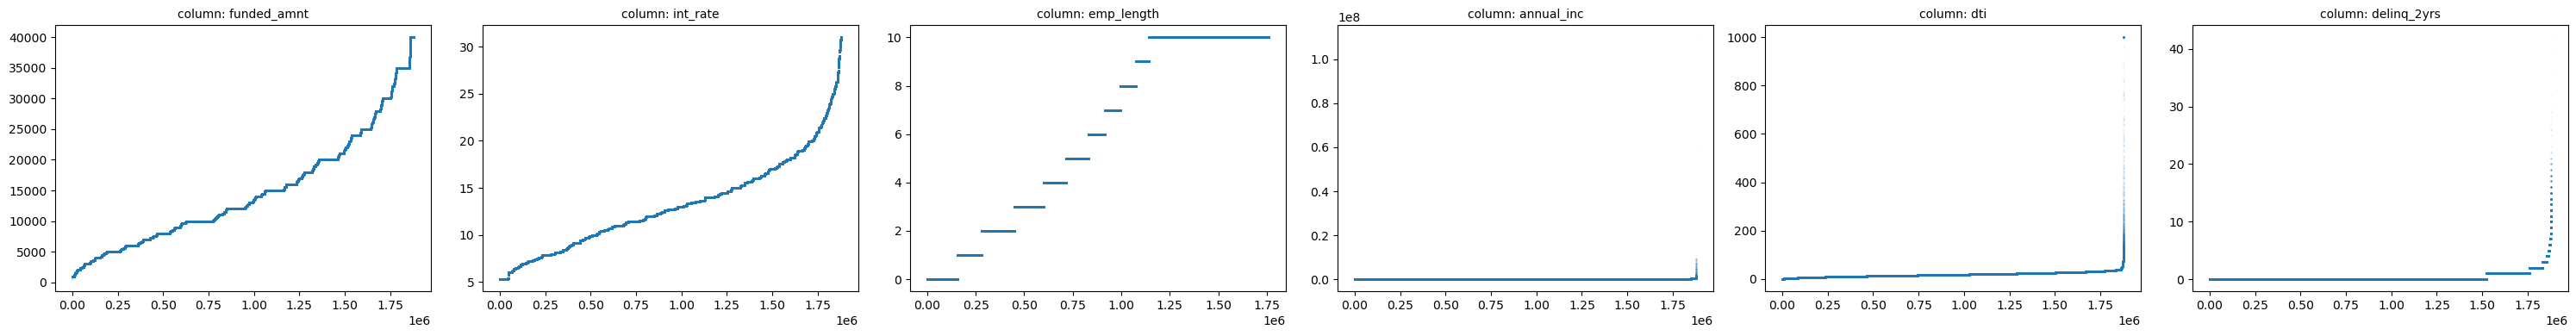

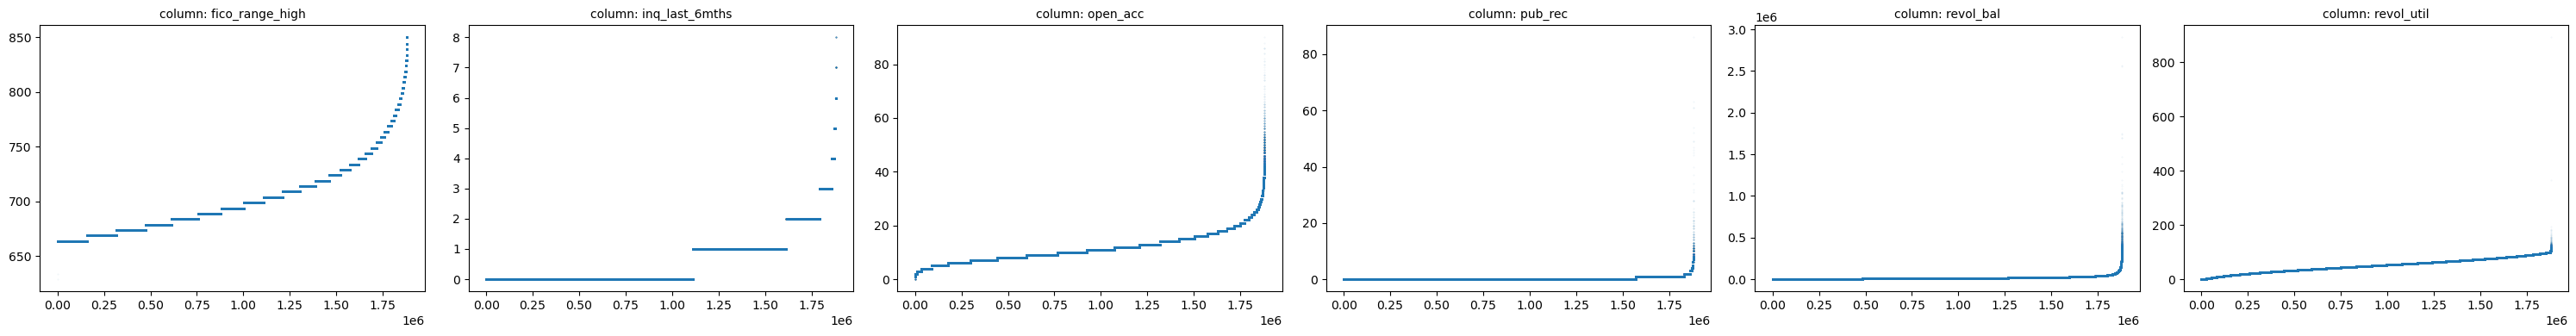

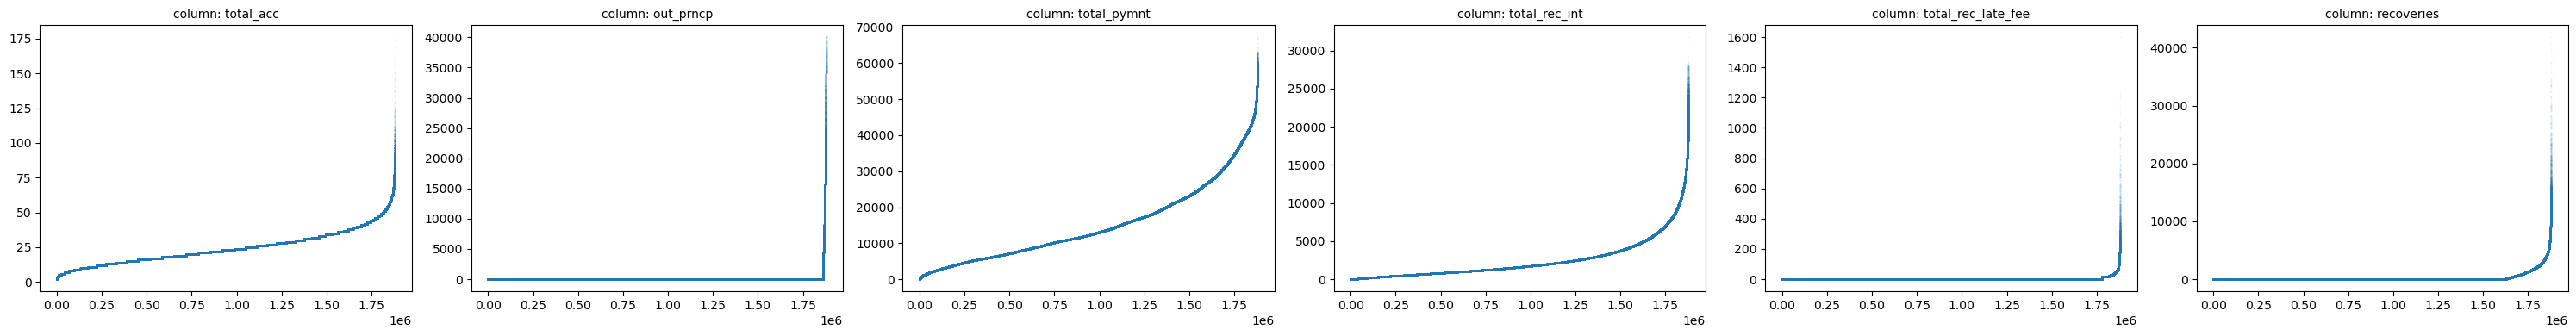

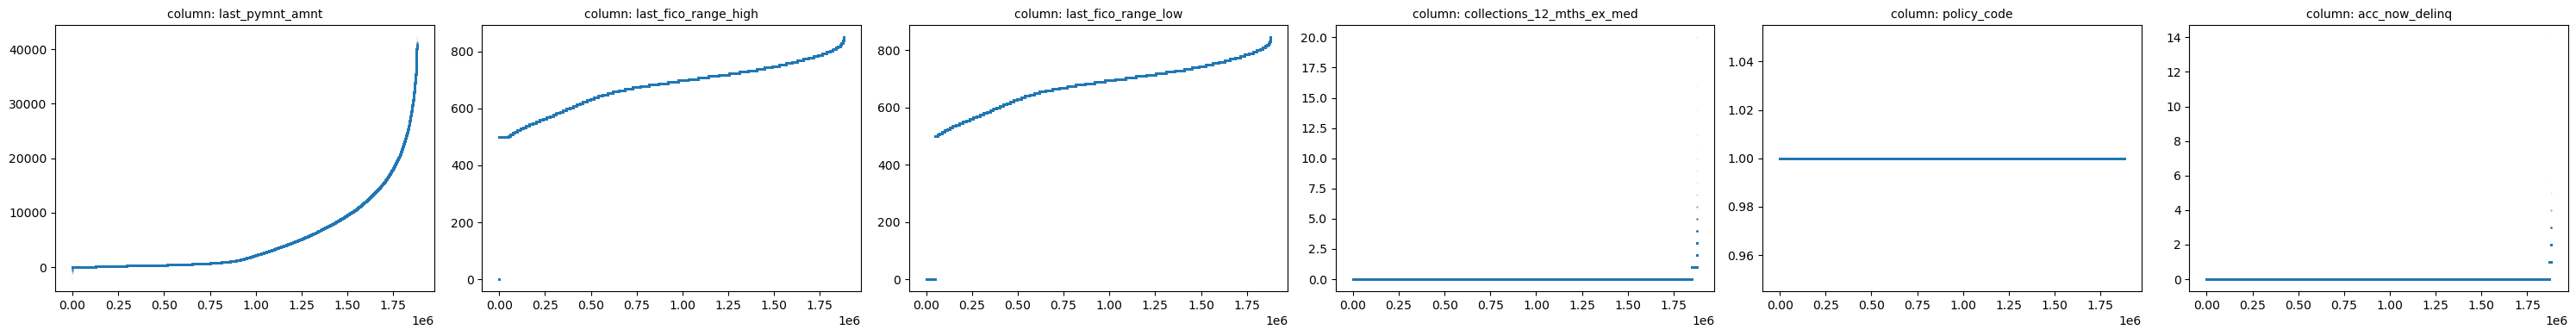

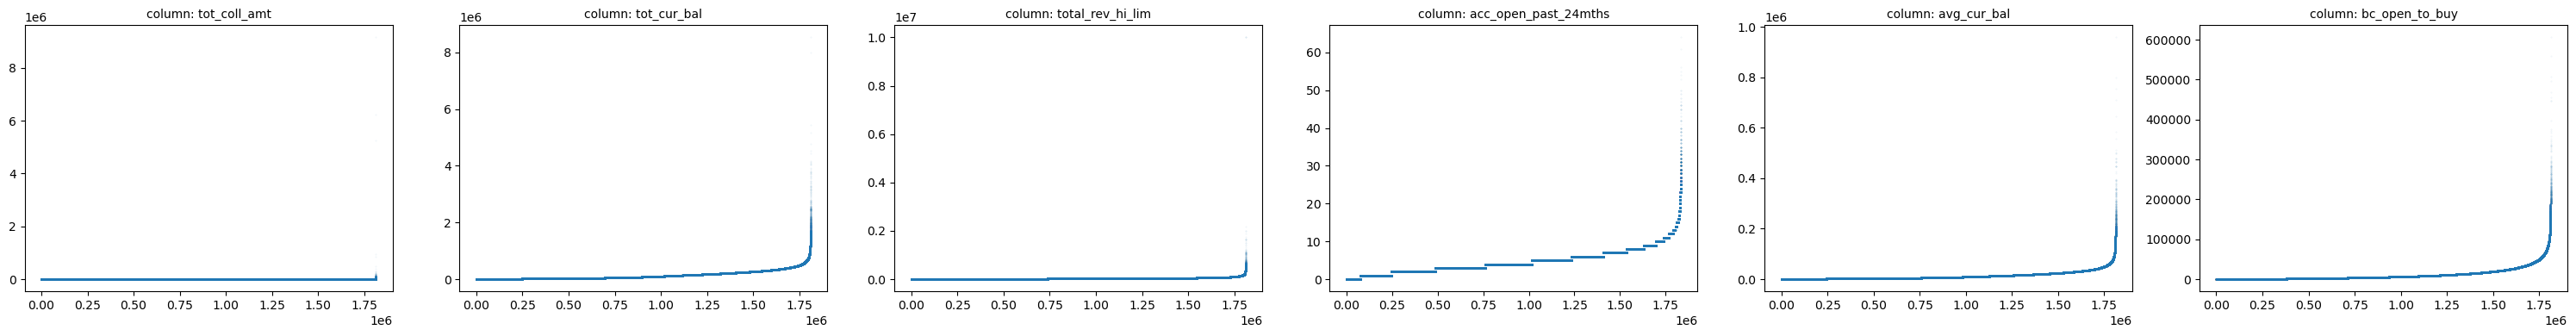

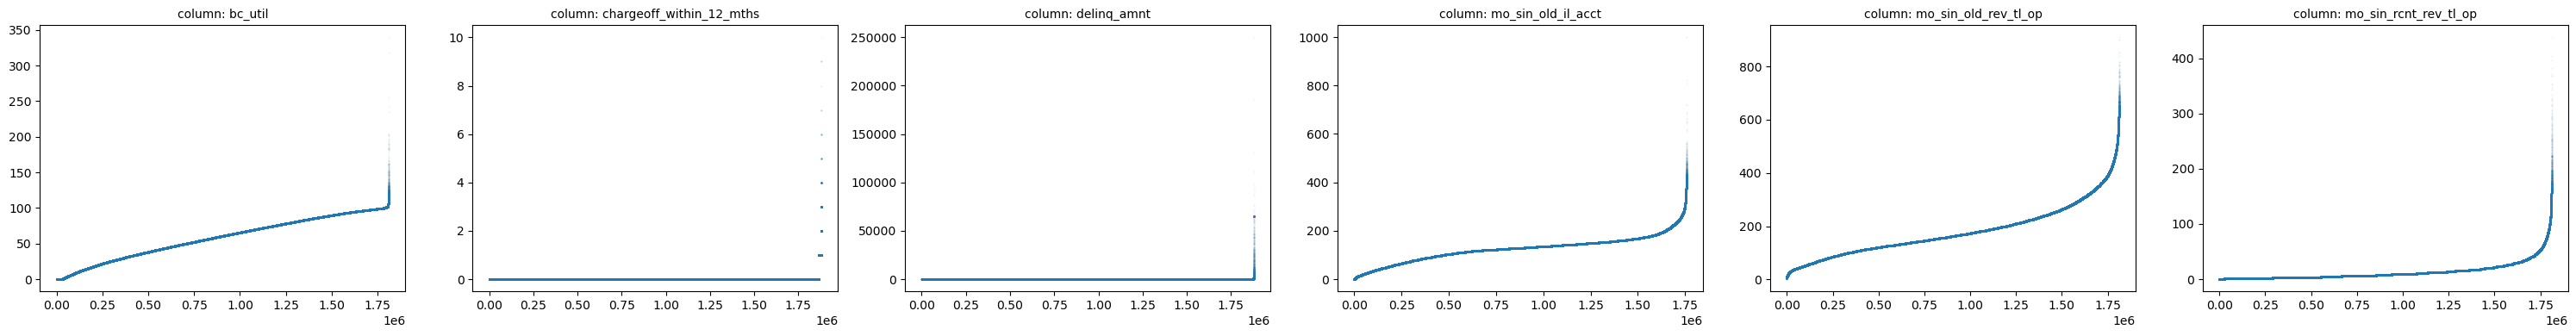

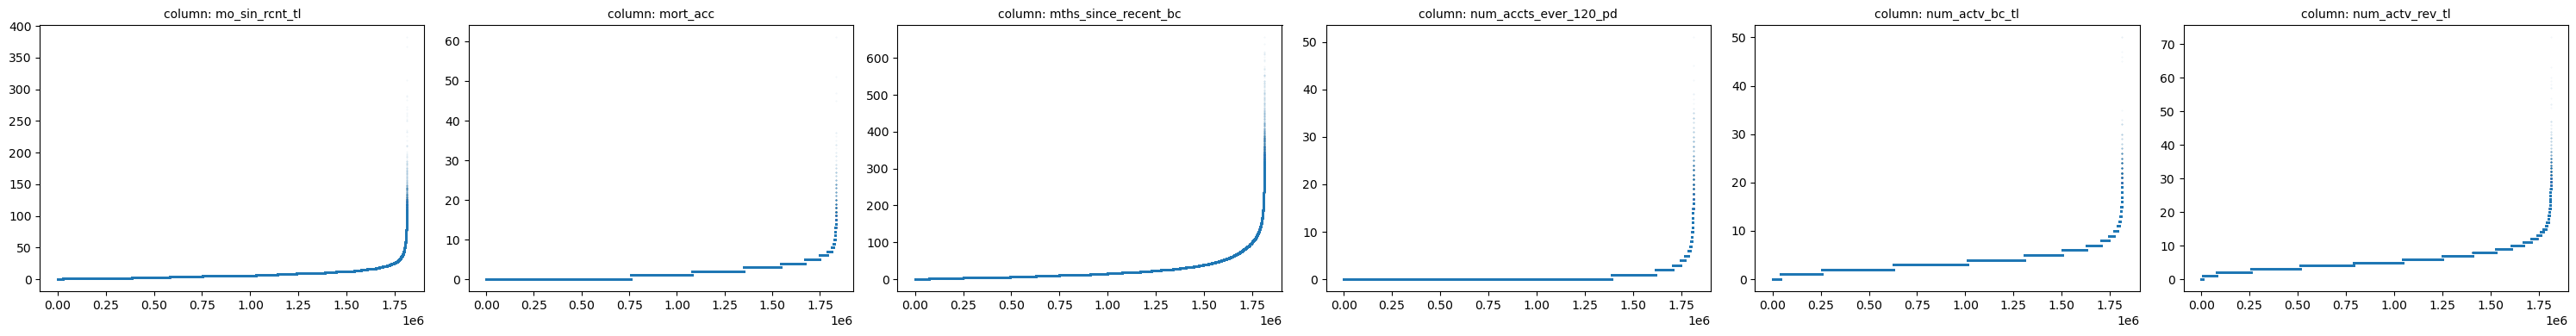

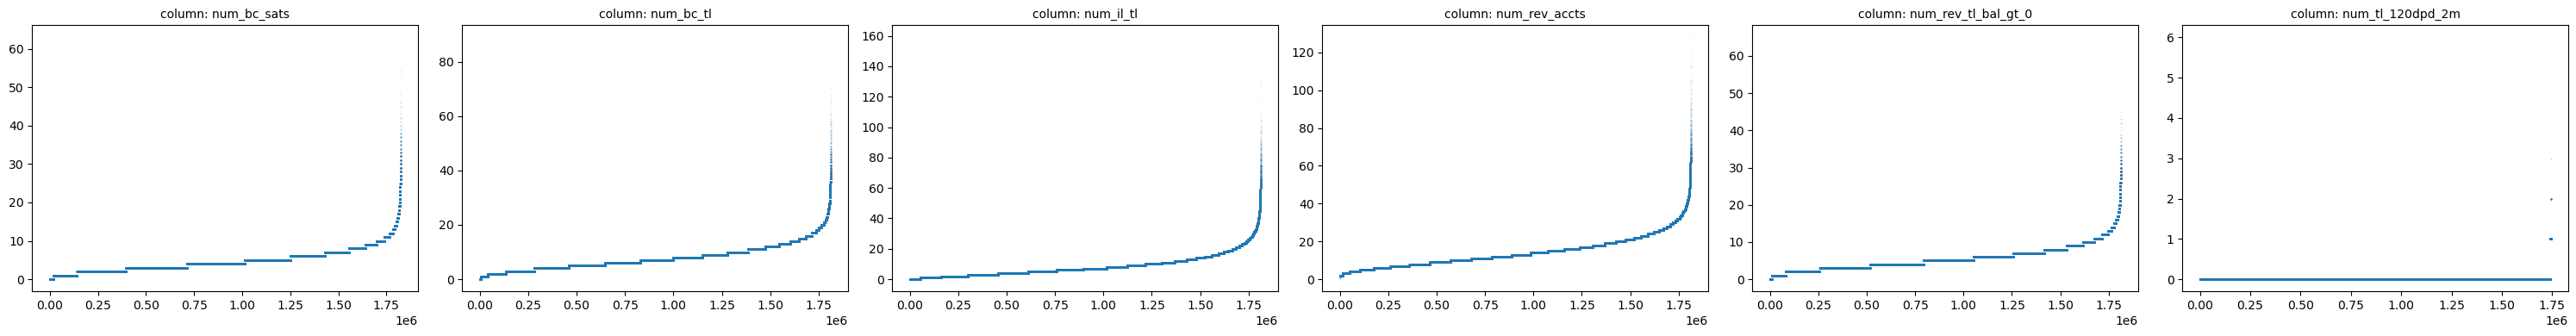

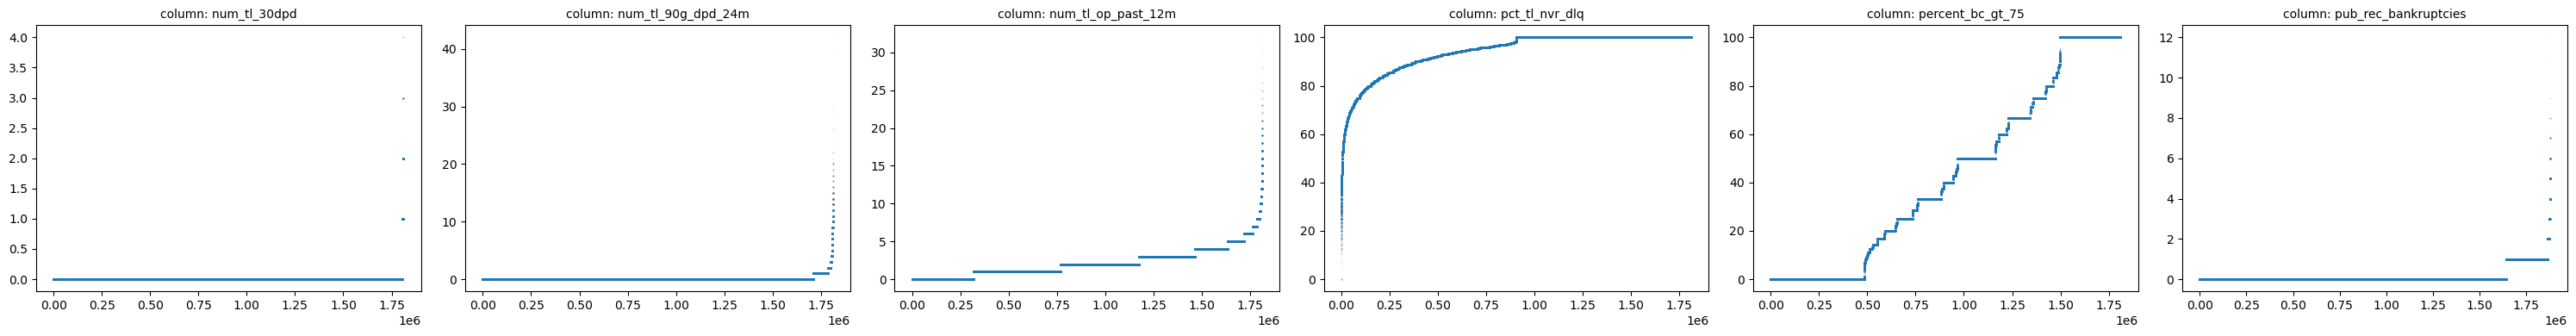

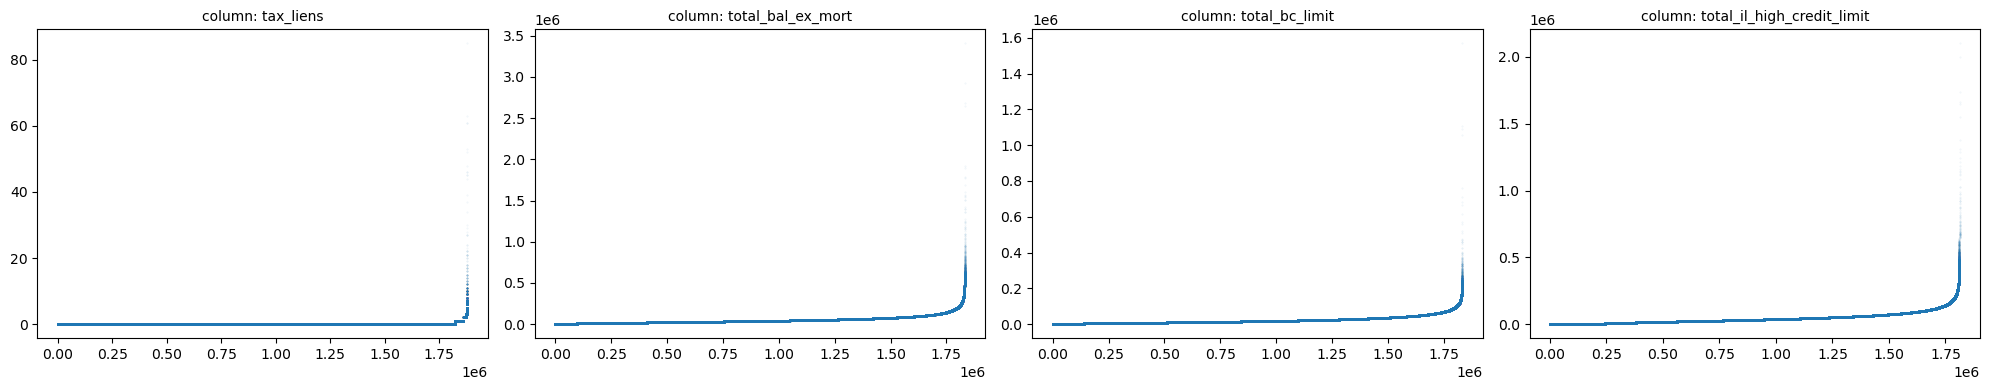

In [ ]:
# 한 번에 그릴 열 개수
cols_per_plot = 6

# 전체 열을 6개씩 끊어서 반복
for i in range(0, len(cont_col), cols_per_plot):
    subset = cont_col[i:i + cols_per_plot]
    
    # subplot 설정
    fig, axes = plt.subplots(1, len(subset), figsize=(5 * len(subset), 4))
    
    # axes가 1개일 경우를 대비해 리스트처럼 처리
    if len(subset) == 1:
        axes = [axes]
    
    for ax, c in zip(axes, subset):
        ax.scatter(x=range(df.shape[0]), y=df.loc[:, c].sort_values(), s=0.1, alpha=0.1)
        ax.set_title(f'column: {c}', fontsize=10)
    
    plt.tight_layout()
    plt.show()


In [ ]:
upper_limits = {
    'annual_inc': 2000000,
    'dti': 800,
    'delinq_2yrs': 30,
    'open_acc': 70,
    'pub_rec': 40,
    'revol_bal': 1500000,
    'revol_util': 150,
    'total_acc': 125,
    'tot_cur_bal': 4000000,
    'total_rev_hi_lim': 2000000,
    'bc_util': 200,
    'delinq_amnt': 80000,
    'mort_acc': 40,
    'tax_liens': 30,
    'total_bal_ex_mort': 2000000,
    'total_bc_limit': 600000
}

# 각 변수에 대해 clip 적용
for col, limit in upper_limits.items():
    if col in df.columns:
        df[col] = df[col].clip(upper=limit)

In [ ]:
lower_limits = {
    'last_pymnt_amnt': 0,
    'last_fico_range_high': 400,
    'last_fico_range_low': 400
}

# 각 변수에 대해 clip 하한값 적용
for col, lower in lower_limits.items():
    if col in df.columns:
        df[col] = df[col].clip(lower=lower)

In [ ]:
drop_cols = [
    'policy_code',
    'acc_now_delinq',
    'tot_coll_amt',
    'chargeoff_within_12_mths',
    'num_tl_120dpd_2m',
    'num_tl_30dpd',
    'num_tl_90g_dpd_24m'
]

# 해당 열이 존재하는 경우에만 삭제
df.drop(drop_cols, axis = 1, inplace = True)

In [ ]:
cont_col = df.select_dtypes('float64').columns

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1879637 entries, 0 to 2925492
Data columns (total 57 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   funded_amnt                 float64
 1   term                        int32  
 2   int_rate                    float64
 3   emp_length                  float64
 4   home_ownership              object 
 5   annual_inc                  float64
 6   verification_status         object 
 7   purpose                     object 
 8   dti                         float64
 9   delinq_2yrs                 float64
 10  fico_range_high             float64
 11  inq_last_6mths              float64
 12  open_acc                    float64
 13  pub_rec                     float64
 14  revol_bal                   float64
 15  revol_util                  float64
 16  total_acc                   float64
 17  out_prncp                   float64
 18  total_pymnt                 float64
 19  total_rec_int             

- 이상치 확인 결과 드롭할 7개 컬럼 제거한 나머지 컬럼들 이상치 작업 후

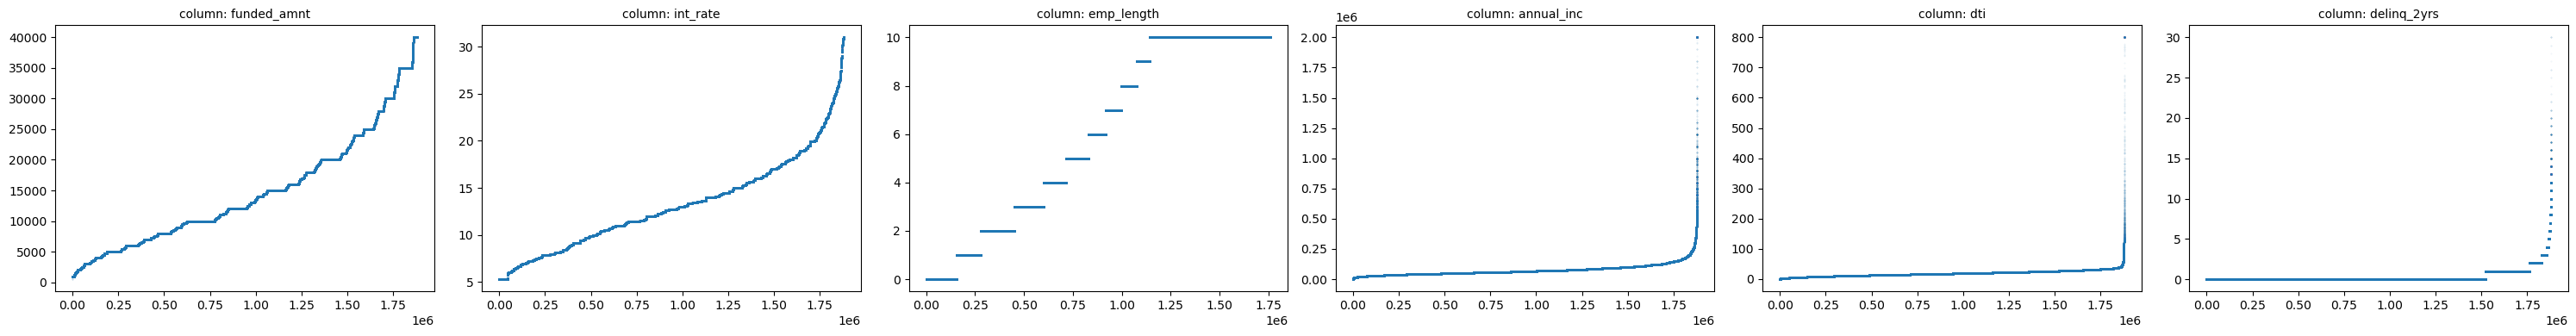

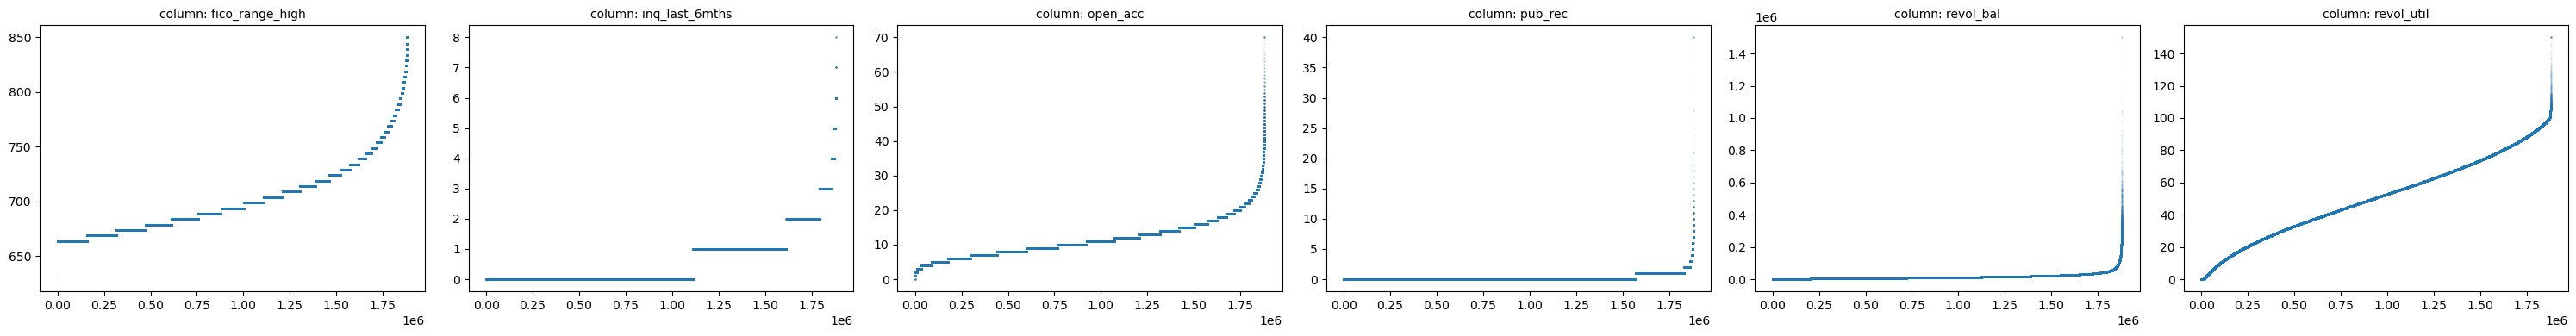

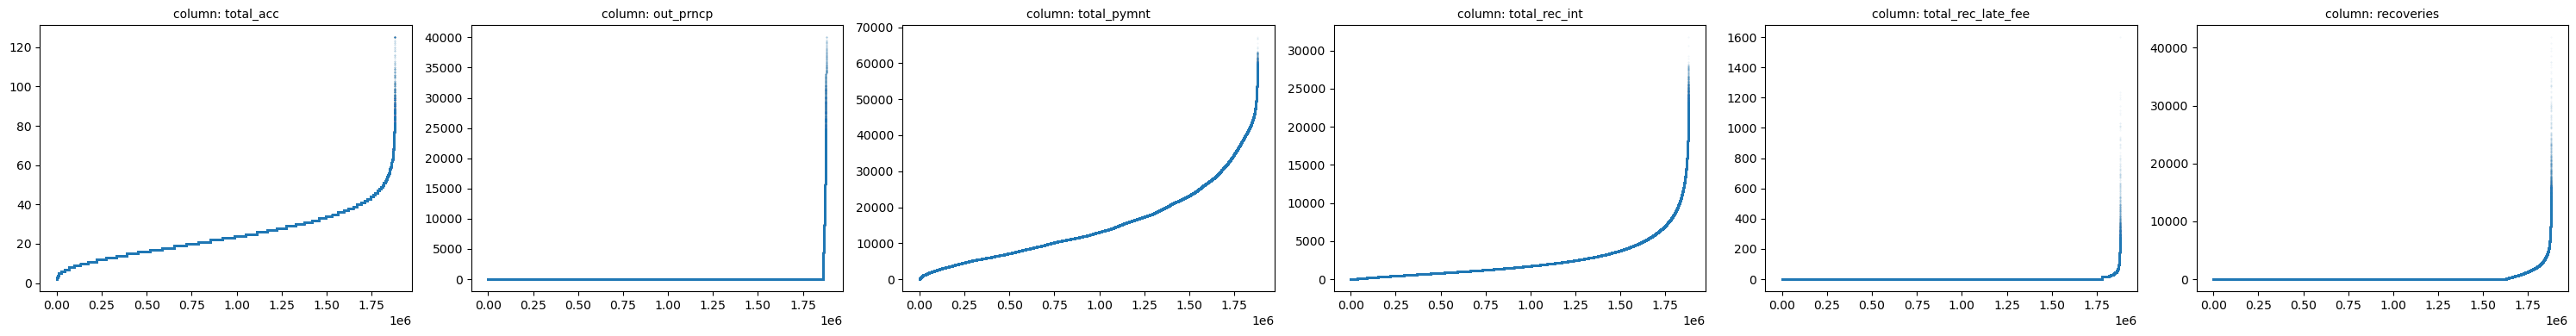

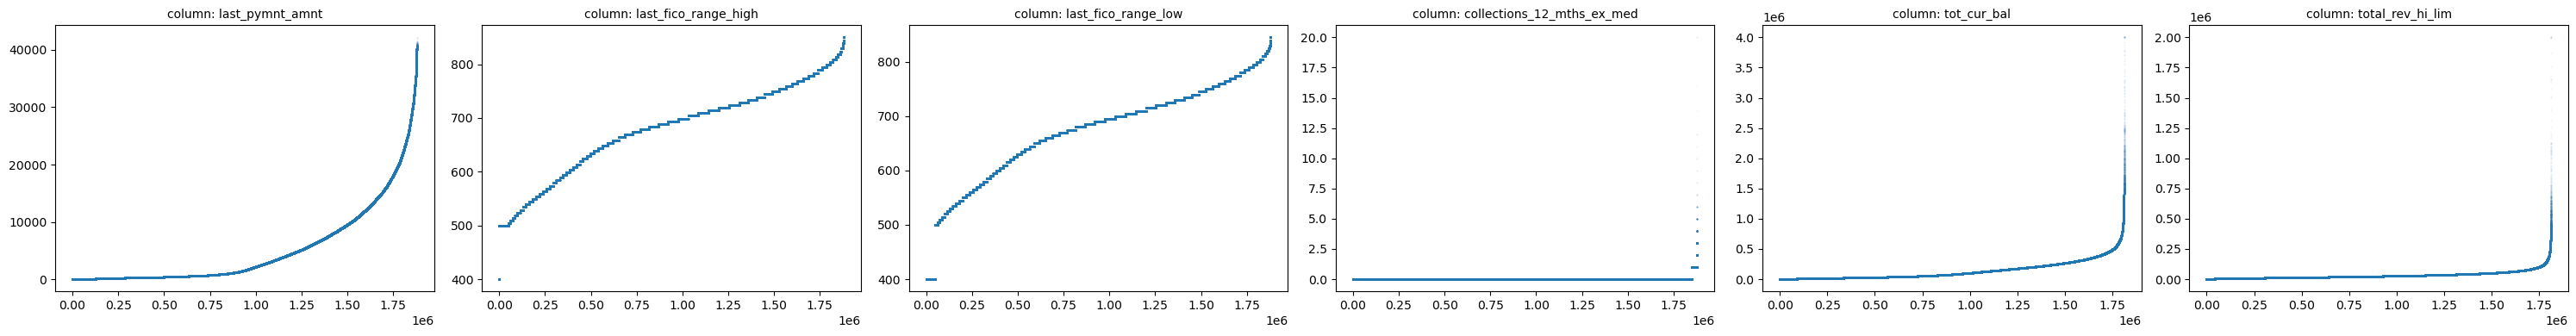

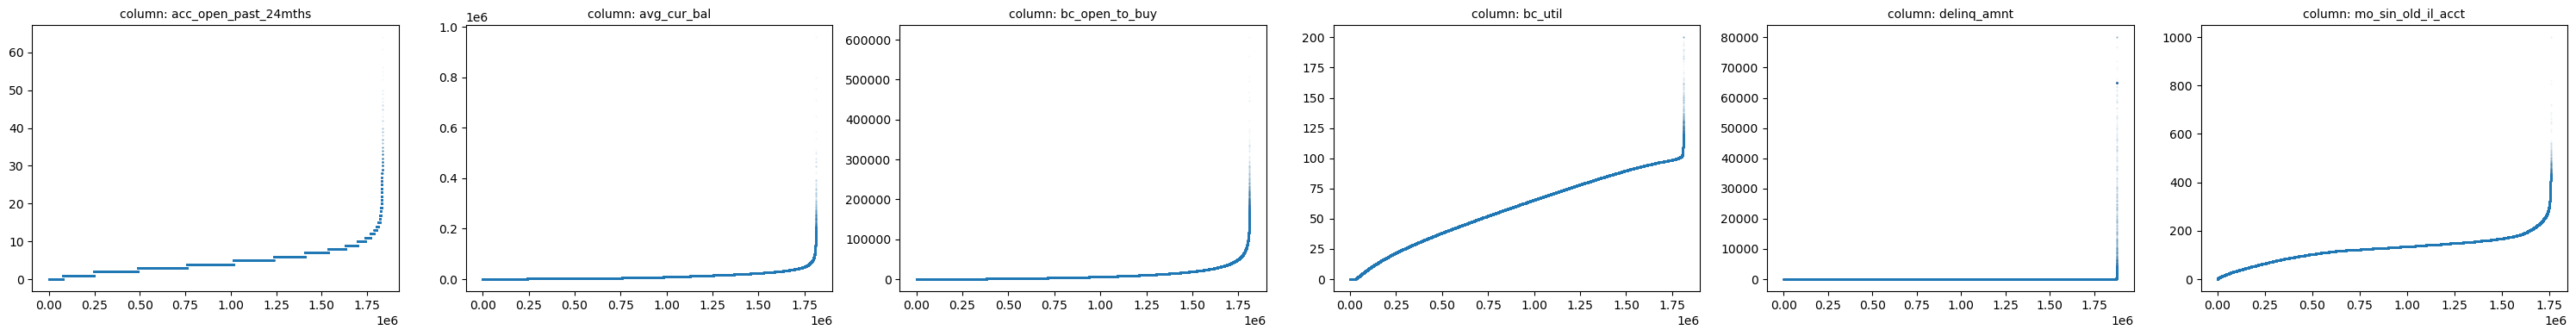

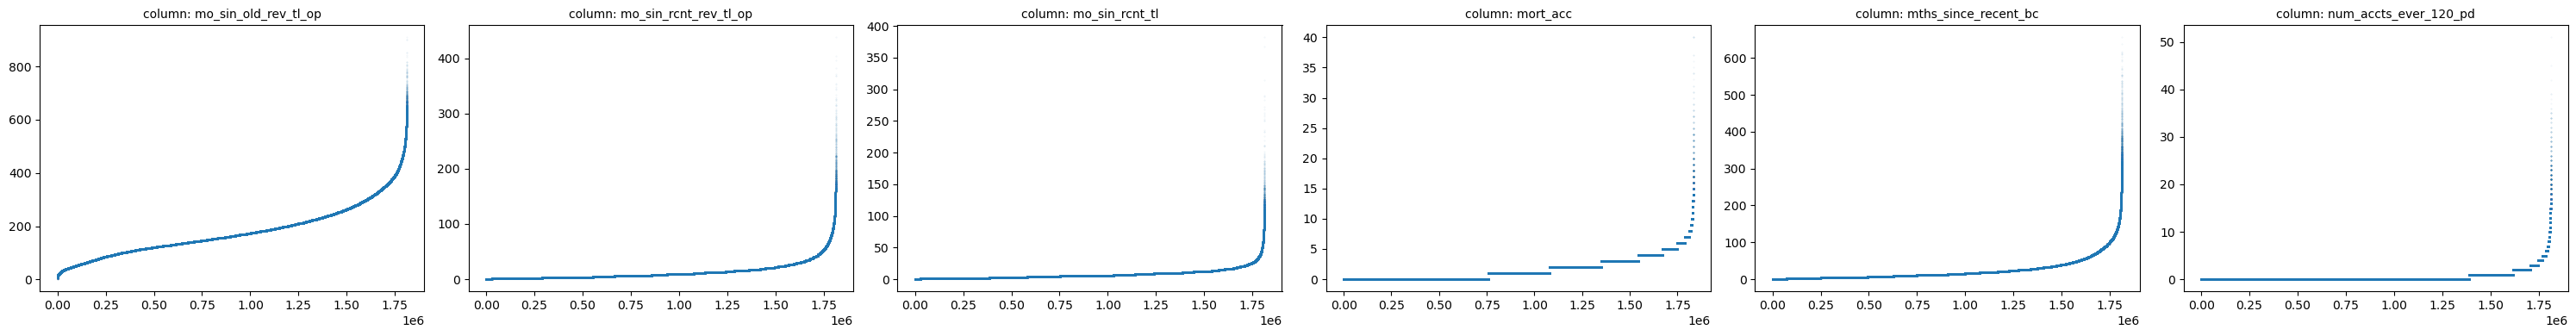

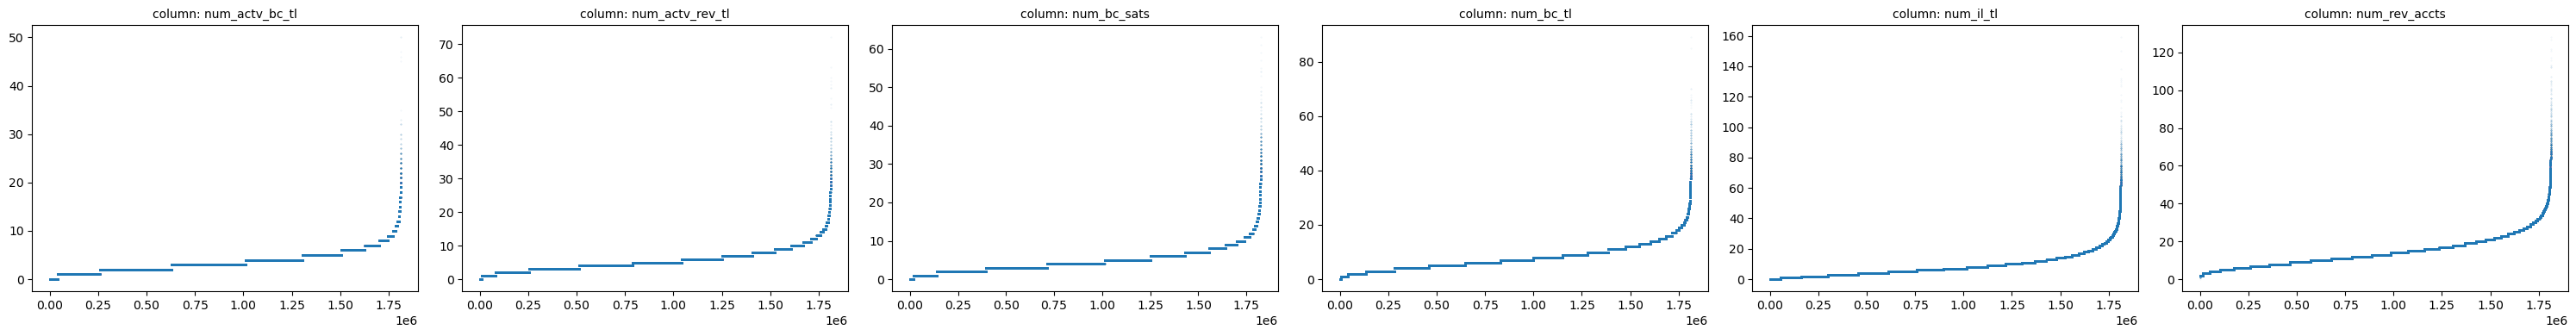

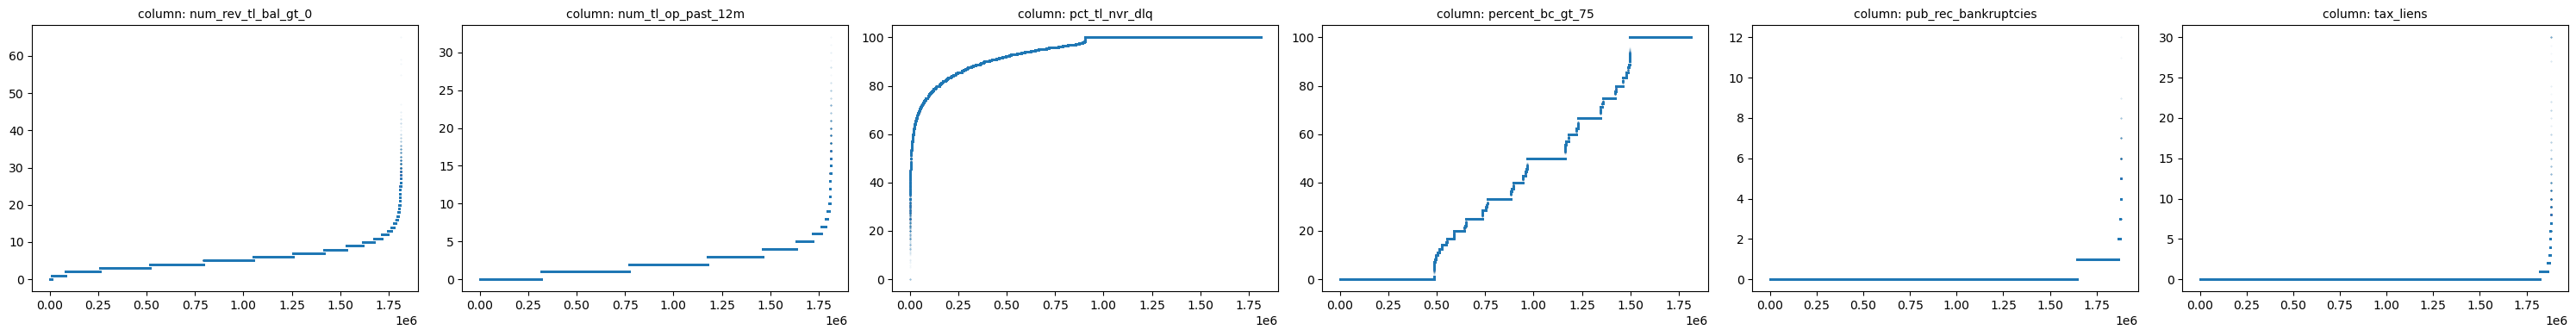

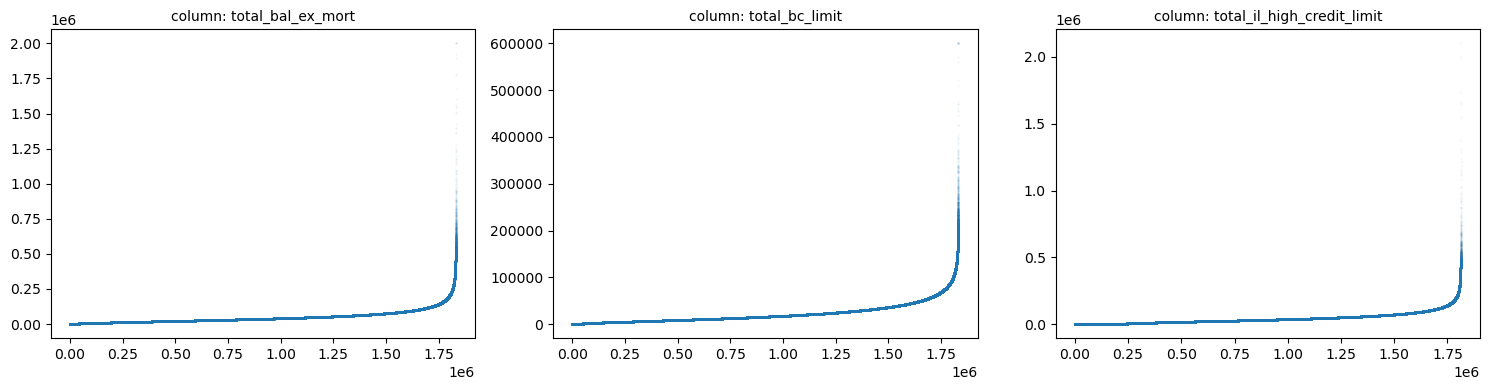

In [ ]:
# 한 번에 그릴 열 개수
cols_per_plot = 6

# 전체 열을 6개씩 끊어서 반복
for i in range(0, len(cont_col), cols_per_plot):
    subset = cont_col[i:i + cols_per_plot]
    
    # subplot 설정
    fig, axes = plt.subplots(1, len(subset), figsize=(5 * len(subset), 4))
    
    # axes가 1개일 경우를 대비해 리스트처럼 처리
    if len(subset) == 1:
        axes = [axes]
    
    for ax, c in zip(axes, subset):
        ax.scatter(x=range(df.shape[0]), y=df.loc[:, c].sort_values(), s=0.1, alpha=0.1)
        ax.set_title(f'column: {c}', fontsize=10)
    
    plt.tight_layout()
    plt.show()

In [ ]:
df.columns.tolist() # 57개로 컬럼 줄음

['funded_amnt',
 'term',
 'int_rate',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'purpose',
 'dti',
 'delinq_2yrs',
 'fico_range_high',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'out_prncp',
 'total_pymnt',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'last_pymnt_amnt',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'tot_cur_bal',
 'total_rev_hi_lim',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'delinq_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_tl_op_past_12m',
 'pct_tl_nvr_dlq',
 'percent_bc_gt_75',
 'pub_rec_bankruptcies',
 'tax_liens',
 'total_bal_ex_mort',
 'total_bc_limit',
 'total_il

In [ ]:
drop_cols = [
        'bc_util', 'pub_rec_bankruptcies', 'mths_since_recent_bc', 'num_bc_sats', 'num_accts_ever_120_pd', 'num_actv_rev_tl', 
        'mo_sin_rcnt_tl', 'total_rec_int', 'pub_rec', 'num_actv_bc_tl', 'bc_open_to_buy', 'acc_open_past_24mths', 'avg_cur_bal', 
        'last_fico_range_high', 'last_pymnt_amnt', 'tax_liens', 'total_il_high_credit_limit', 'collections_12_mths_ex_med', 'recoveries', 
        'num_bc_tl', 'debt_settlement_flag', 'delinq_amnt', 'pct_tl_nvr_dlq', 'total_acc', 'total_rec_late_fee', 'num_il_tl', 'total_pymnt', 
        'open_acc', 'inq_last_6mths', 'total_bal_ex_mort', 'tot_cur_bal', 'last_fico_range_low', 'delinq_2yrs', 'revol_bal', 'revol_util',
        'mo_sin_rcnt_rev_tl_op', 'total_bc_limit', 'total_rev_hi_lim', 'num_rev_accts', 'out_prncp', 'mo_sin_old_rev_tl_op', 'mo_sin_old_il_acct',
        'percent_bc_gt_75', 'num_tl_op_past_12m'
        ]


# 해당 열이 존재하는 경우에만 삭제
df.drop(drop_cols, axis = 1, inplace = True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1879637 entries, 0 to 2925492
Data columns (total 13 columns):
 #   Column               Dtype  
---  ------               -----  
 0   funded_amnt          float64
 1   term                 int32  
 2   int_rate             float64
 3   emp_length           float64
 4   home_ownership       object 
 5   annual_inc           float64
 6   verification_status  object 
 7   purpose              object 
 8   dti                  float64
 9   fico_range_high      float64
 10  mort_acc             float64
 11  num_rev_tl_bal_gt_0  float64
 12  loan_status_binary   int32  
dtypes: float64(8), int32(2), object(3)
memory usage: 186.4+ MB


## 로그 변환 필요한것들 확인

In [ ]:
cont_col2 = df.select_dtypes('float64').columns

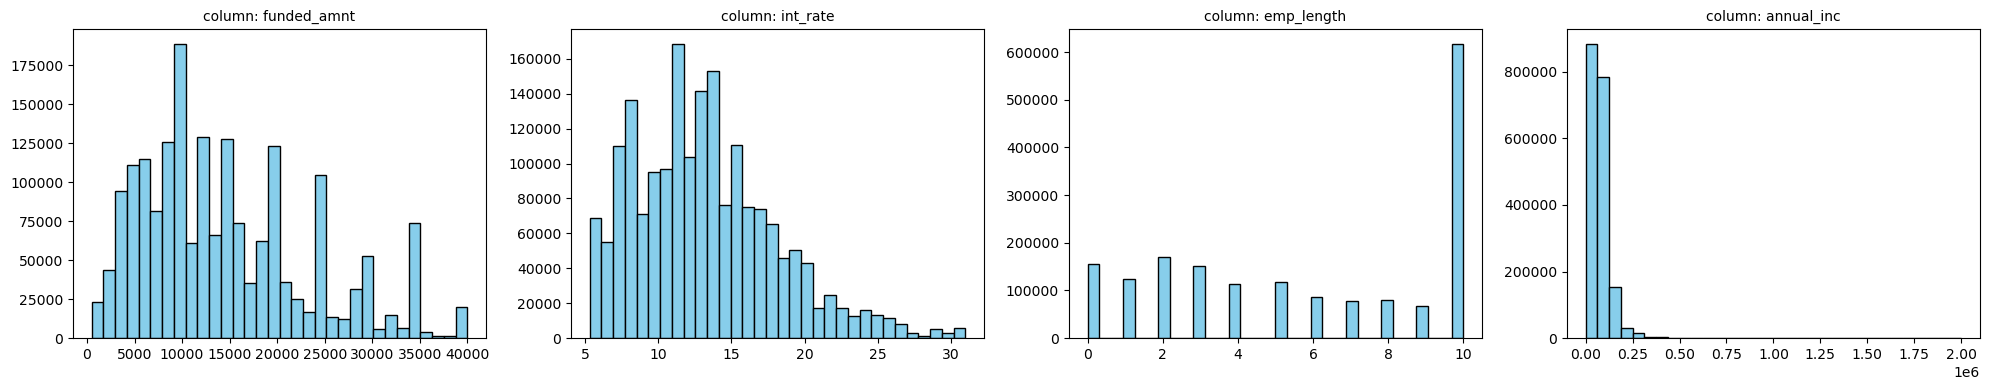

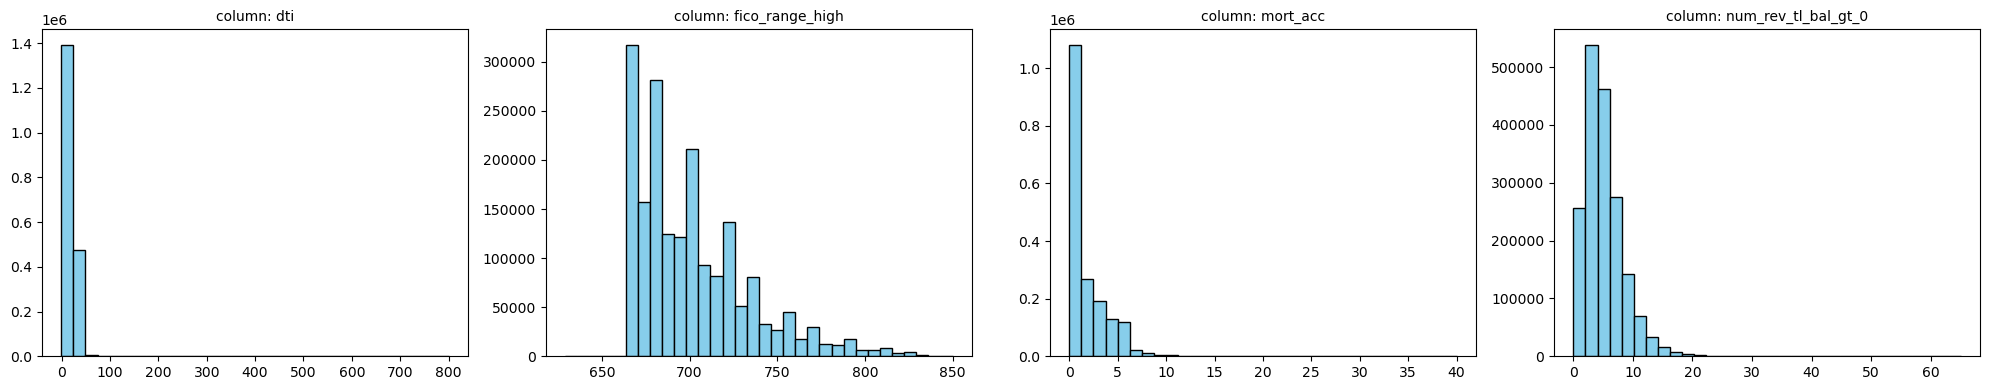

In [ ]:
# 한 화면에 그릴 열 개수
cols_per_plot = 4

# 전체 열을 6개씩 끊어서 반복
for i in range(0, len(cont_col2), cols_per_plot):
    subset = cont_col2[i:i + cols_per_plot]
    
    # subplot 설정 (1행 n열)
    fig, axes = plt.subplots(1, len(subset), figsize=(5 * len(subset), 4))
    
    # axes가 1개일 경우에도 iterable하게 처리
    if len(subset) == 1:
        axes = [axes]
    
    # 각 subplot에 히스토그램 그리기
    for ax, c in zip(axes, subset):
        ax.hist(df[c].dropna(), bins=32, color='skyblue', edgecolor='black')
        ax.set_title(f'column: {c}', fontsize=10)
    
    plt.tight_layout()
    plt.show()

In [ ]:
for c in ['annual_inc', 'dti', 'mort_acc']:
    df[c] = np.log(df[c]+ 10)

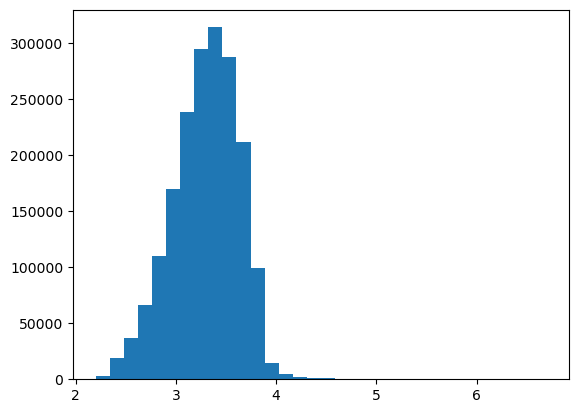

In [ ]:
plt.hist(df.dti, bins = 32)
plt.show()

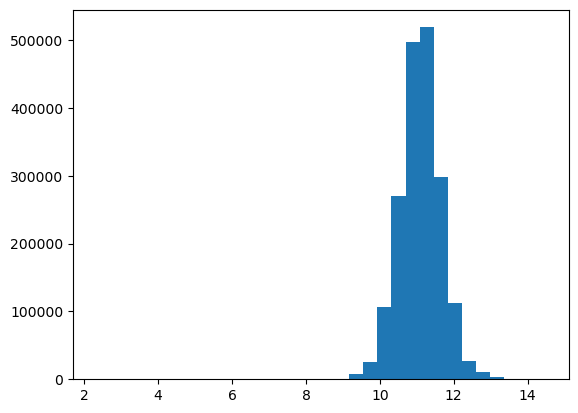

In [ ]:
plt.hist(df.annual_inc, bins = 32)
plt.show()

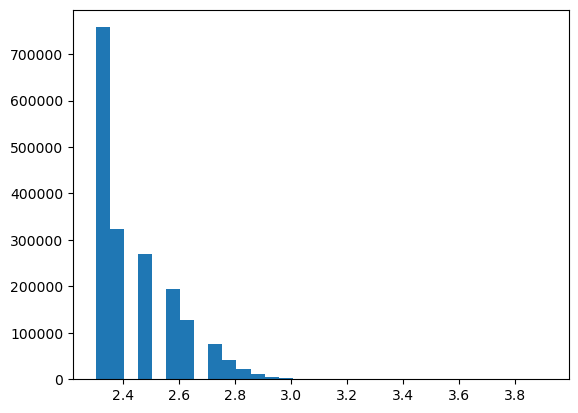

In [ ]:
plt.hist(df.mort_acc, bins = 32)
plt.show()

In [ ]:
# 결측치 확인 및 처리
np.sum(df.isna())

c:\Users\host\anaconda3\envs\study\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


funded_amnt                 0
term                        0
int_rate                    0
emp_length             119490
home_ownership              0
annual_inc                  0
verification_status         0
purpose                     0
dti                      1143
fico_range_high             0
mort_acc                47281
num_rev_tl_bal_gt_0     67527
loan_status_binary          0
dtype: int64

In [ ]:
df.dropna(inplace = True)
df.reset_index(inplace = True, drop = True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1694568 entries, 0 to 1694567
Data columns (total 13 columns):
 #   Column               Dtype  
---  ------               -----  
 0   funded_amnt          float64
 1   term                 int32  
 2   int_rate             float64
 3   emp_length           float64
 4   home_ownership       object 
 5   annual_inc           float64
 6   verification_status  object 
 7   purpose              object 
 8   dti                  float64
 9   fico_range_high      float64
 10  mort_acc             float64
 11  num_rev_tl_bal_gt_0  float64
 12  loan_status_binary   int32  
dtypes: float64(8), int32(2), object(3)
memory usage: 155.1+ MB


- 최종 선택된 컬럼들 One-Hot-Encoding

In [ ]:
final_features = [
    'int_rate', 'dti', 'home_ownership', 'purpose', 'annual_inc', 'funded_amnt',
    'mort_acc', 'fico_range_high', 'term', 'emp_length', 'num_rev_tl_bal_gt_0', 'verification_status'
]

X = df[final_features]

In [ ]:
# import pickle

# # 문자열(범주형) 컬럼 찾기
# categorical_cols = X.select_dtypes(include='object').columns.tolist()

# # One-Hot Encoding 적용
# X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# # 인코딩된 데이터프레임을 피클 파일로 저장
# with open("encoded_data.pkl", "wb") as f:
#     pickle.dump(X_encoded, f)

# print("One-Hot Encoding 된 데이터가 'encoded_data.pkl'로 저장되었습니다.")

In [ ]:
# # 인코딩 전 범주형 컬럼별 고유값 수 확인
# for col in categorical_cols:
#     print(f"{col} → {df[col].nunique()}개의 범주")


home_ownership → 6개의 범주
purpose → 14개의 범주
verification_status → 3개의 범주


- MinMaxScaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import pickle

# 1. 수치형 열만 선택
numeric_df = df.select_dtypes(include='number')

# 2. MinMaxScaler 적용
scaler = MinMaxScaler()
scaled_array = scaler.fit_transform(numeric_df)

# 3. 다시 DataFrame으로 변환 (열 이름 유지)
scaled_df = pd.DataFrame(scaled_array, columns=numeric_df.columns, index=df.index)
df[numeric_df.columns] = scaled_df

# 4. MinMaxScaler 객체를 피클 파일로 저장
with open("minmax_scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("MinMaxScaler 객체가 'minmax_scaler.pkl'로 저장되었습니다.")

MinMaxScaler 객체가 'minmax_scaler.pkl'로 저장되었습니다.


In [ ]:
df.select_dtypes(include='number')

,funded_amnt,term,int_rate,emp_length,annual_inc,dti,fico_range_high,mort_acc,num_rev_tl_bal_gt_0,loan_status_binary
0,0.282051,0.0,0.221184,0.4,0.712734,0.107819,0.322581,0.000000,0.107692,1.0
1,0.097436,0.0,0.221184,0.2,0.678699,0.072826,0.510753,0.000000,0.030769,1.0
2,0.667949,0.0,0.221184,1.0,0.705606,0.287865,0.376344,0.209062,0.061538,1.0
3,0.282051,0.0,0.089953,0.3,0.751660,0.204713,0.241935,0.059220,0.076923,1.0
4,0.333333,0.0,0.293614,0.4,0.744106,0.177676,0.053763,0.000000,0.061538,1.0
...,...,...,...,...,...,...,...,...,...,...
1694563,0.589744,1.0,0.727414,0.0,0.760121,0.195071,0.053763,0.000000,0.107692,0.0
1694564,0.230769,0.0,0.104361,1.0,0.719290,0.264202,0.349462,0.000000,0.123077,1.0
1694565,0.232051,0.0,0.454829,0.8,0.673137,0.271671,0.241935,0.000000,0.200000,0.0
1694566,0.128205,0.0,0.238707,0.5,0.681545,0.267487,0.053763,0.000000,0.046154,1.0


In [ ]:
numeric_df.columns

Index(['funded_amnt', 'term', 'int_rate', 'emp_length', 'annual_inc', 'dti',
       'fico_range_high', 'mort_acc', 'num_rev_tl_bal_gt_0',
       'loan_status_binary'],
      dtype='object')

In [ ]:
scaled_array.shape

(1694568, 10)

In [ ]:
df = df.astype({col: 'float16' for col in df.select_dtypes(include=['float64']).columns})

In [ ]:
df.head()

,funded_amnt,term,int_rate,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,fico_range_high,mort_acc,num_rev_tl_bal_gt_0,loan_status_binary
0,0.281982,0.0,0.221191,0.399902,RENT,0.712891,Not Verified,debt_consolidation,0.107849,0.322510,0.000000,0.107666,1.0
1,0.097412,0.0,0.221191,0.199951,MORTGAGE,0.678711,Source Verified,home_improvement,0.072815,0.510742,0.000000,0.030762,1.0
2,0.667969,0.0,0.221191,1.000000,OWN,0.705566,Verified,debt_consolidation,0.287842,0.376465,0.209106,0.061523,1.0
3,0.281982,0.0,0.089966,0.300049,MORTGAGE,0.751465,Not Verified,debt_consolidation,0.204712,0.241943,0.059235,0.076904,1.0
4,0.333252,0.0,0.293701,0.399902,RENT,0.744141,Not Verified,debt_consolidation,0.177734,0.053772,0.000000,0.061523,1.0


#  모델링

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, recall_score, precision_score, f1_score
import pandas as pd

In [ ]:
import pickle
from sklearn.preprocessing import LabelEncoder

# 종속 변수 (타겟 변수) 설정
y = df['loan_status_binary']

# 독립 변수 (특징 변수) 설정
X = df.drop(columns=['loan_status_binary'])

# 범주형 컬럼 리스트
categorical_cols = X.select_dtypes(include='object').columns.tolist()

# 각 범주형 컬럼에 대해 LabelEncoder 적용
label_encoders = {}
for col in categorical_cols:
    label_encoder = LabelEncoder()
    X[col] = label_encoder.fit_transform(X[col].astype(str))
    label_encoders[col] = label_encoder

# LabelEncoder 객체들을 피클 파일로 저장
with open("label_encoders.pkl", "wb") as f:
    pickle.dump(label_encoders, f)

# X와 y 확인
print("독립 변수 (X):", X.columns)
print("종속 변수 (y):", y.name)


독립 변수 (X): Index(['funded_amnt', 'term', 'int_rate', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'purpose', 'dti',
       'fico_range_high', 'mort_acc', 'num_rev_tl_bal_gt_0'],
      dtype='object')
종속 변수 (y): loan_status_binary


In [ ]:
df

,funded_amnt,term,int_rate,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,fico_range_high,mort_acc,num_rev_tl_bal_gt_0,loan_status_binary
0,0.281982,0.0,0.221191,0.399902,RENT,0.712891,Not Verified,debt_consolidation,0.107849,0.322510,0.000000,0.107666,1.0
1,0.097412,0.0,0.221191,0.199951,MORTGAGE,0.678711,Source Verified,home_improvement,0.072815,0.510742,0.000000,0.030762,1.0
2,0.667969,0.0,0.221191,1.000000,OWN,0.705566,Verified,debt_consolidation,0.287842,0.376465,0.209106,0.061523,1.0
3,0.281982,0.0,0.089966,0.300049,MORTGAGE,0.751465,Not Verified,debt_consolidation,0.204712,0.241943,0.059235,0.076904,1.0
4,0.333252,0.0,0.293701,0.399902,RENT,0.744141,Not Verified,debt_consolidation,0.177734,0.053772,0.000000,0.061523,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1694563,0.589844,1.0,0.727539,0.000000,RENT,0.760254,Source Verified,other,0.195068,0.053772,0.000000,0.107666,0.0
1694564,0.230713,0.0,0.104370,1.000000,MORTGAGE,0.719238,Source Verified,debt_consolidation,0.264160,0.349365,0.000000,0.123047,1.0
1694565,0.232056,0.0,0.454834,0.799805,RENT,0.673340,Not Verified,debt_consolidation,0.271729,0.241943,0.000000,0.199951,0.0
1694566,0.128174,0.0,0.238647,0.500000,RENT,0.681641,Source Verified,credit_card,0.267578,0.053772,0.000000,0.046143,1.0


In [ ]:
X

,funded_amnt,term,int_rate,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,fico_range_high,mort_acc,num_rev_tl_bal_gt_0
0,0.281982,0.0,0.221191,0.399902,5,0.712891,0,2,0.107849,0.322510,0.000000,0.107666
1,0.097412,0.0,0.221191,0.199951,1,0.678711,1,4,0.072815,0.510742,0.000000,0.030762
2,0.667969,0.0,0.221191,1.000000,4,0.705566,2,2,0.287842,0.376465,0.209106,0.061523
3,0.281982,0.0,0.089966,0.300049,1,0.751465,0,2,0.204712,0.241943,0.059235,0.076904
4,0.333252,0.0,0.293701,0.399902,5,0.744141,0,2,0.177734,0.053772,0.000000,0.061523
...,...,...,...,...,...,...,...,...,...,...,...,...
1694563,0.589844,1.0,0.727539,0.000000,5,0.760254,1,9,0.195068,0.053772,0.000000,0.107666
1694564,0.230713,0.0,0.104370,1.000000,1,0.719238,1,2,0.264160,0.349365,0.000000,0.123047
1694565,0.232056,0.0,0.454834,0.799805,5,0.673340,0,2,0.271729,0.241943,0.000000,0.199951
1694566,0.128174,0.0,0.238647,0.500000,5,0.681641,1,1,0.267578,0.053772,0.000000,0.046143


In [ ]:
# # 종속 변수와 독립 변수 설정
# # 종속 변수 (타겟 변수) 설정
# y = df['loan_status_binary']

# # 독립 변수 (특징 변수) 설정
# X = X_encoded  # 인코딩 + 스케일링 완료된 데이터 사용

# # X_encoded 만들 때 loan_status_binary가 들어있다면 제거
# if 'loan_status_binary' in X.columns:
#     X = X.drop(columns=['loan_status_binary'])

# # X와 y 확인
# print("독립 변수 (X):", X.columns)
# print("종속 변수 (y):", y.name)

# # 변환된 데이터 확인
# df

독립 변수 (X): Index(['int_rate', 'dti', 'annual_inc', 'funded_amnt', 'mort_acc',
       'fico_range_high', 'term', 'emp_length', 'num_rev_tl_bal_gt_0',
       'home_ownership_MORTGAGE', 'home_ownership_NONE',
       'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT',
       'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement', 'purpose_house',
       'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
       'purpose_other', 'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding',
       'verification_status_Source Verified', 'verification_status_Verified'],
      dtype='object')
종속 변수 (y): loan_status_binary


,funded_amnt,term,int_rate,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,fico_range_high,mort_acc,num_rev_tl_bal_gt_0,loan_status_binary
0,0.281982,0.0,0.221191,0.399902,RENT,0.712891,Not Verified,debt_consolidation,0.107849,0.322510,0.000000,0.107666,1.0
1,0.097412,0.0,0.221191,0.199951,MORTGAGE,0.678711,Source Verified,home_improvement,0.072815,0.510742,0.000000,0.030762,1.0
2,0.667969,0.0,0.221191,1.000000,OWN,0.705566,Verified,debt_consolidation,0.287842,0.376465,0.209106,0.061523,1.0
3,0.281982,0.0,0.089966,0.300049,MORTGAGE,0.751465,Not Verified,debt_consolidation,0.204712,0.241943,0.059235,0.076904,1.0
4,0.333252,0.0,0.293701,0.399902,RENT,0.744141,Not Verified,debt_consolidation,0.177734,0.053772,0.000000,0.061523,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1694563,0.589844,1.0,0.727539,0.000000,RENT,0.760254,Source Verified,other,0.195068,0.053772,0.000000,0.107666,0.0
1694564,0.230713,0.0,0.104370,1.000000,MORTGAGE,0.719238,Source Verified,debt_consolidation,0.264160,0.349365,0.000000,0.123047,1.0
1694565,0.232056,0.0,0.454834,0.799805,RENT,0.673340,Not Verified,debt_consolidation,0.271729,0.241943,0.000000,0.199951,0.0
1694566,0.128174,0.0,0.238647,0.500000,RENT,0.681641,Source Verified,credit_card,0.267578,0.053772,0.000000,0.046143,1.0


- 인코딩 잘 됬는지 확인

In [ ]:
# print(X_encoded.head())

   int_rate       dti  annual_inc  funded_amnt  mort_acc  fico_range_high  \
0     10.99  2.682390   11.002266      12000.0  2.302585            724.0   
1     10.99  2.524928   10.586837       4800.0  2.302585            759.0   
2     10.99  3.492560   10.915270      27050.0  2.639057            734.0   
3      7.62  3.118392   11.477402      12000.0  2.397895            709.0   
4     12.85  2.996732   11.385206      14000.0  2.302585            674.0   

   term  emp_length  num_rev_tl_bal_gt_0  home_ownership_MORTGAGE  ...  \
0    36         4.0                  7.0                    False  ...   
1    36         2.0                  2.0                     True  ...   
2    36        10.0                  4.0                    False  ...   
3    36         3.0                  5.0                     True  ...   
4    36         4.0                  4.0                    False  ...   

   purpose_major_purchase  purpose_medical  purpose_moving  purpose_other  \
0              

In [ ]:
# 학습용 데이터를 70%, 나머지 데이터를 30%로 나눔
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42  # 학습 데이터 비율을 70%로 설정
)

# 임시 데이터를 검증용(10%)과 테스트용(20%)으로 나눔
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=2/3, random_state=42  # 테스트 데이터 비율 증가 (전체의 20%), 전체 기준 검증:10%, 테스트:20%
)

In [ ]:
# 각 데이터셋 크기 확인
print('학습용:', X_train.shape, y_train.shape)  # 학습 데이터 70%
print('검증용:', X_val.shape, y_val.shape)      # 검증 데이터 10%
print('테스트용:', X_test.shape, y_test.shape)  # 테스트 데이터 20%

# 1140891 + 162984 + 325970

학습용: (1186197, 12) (1186197,)
검증용: (169457, 12) (169457,)
테스트용: (338914, 12) (338914,)


In [ ]:
# 성능 평가 함수
def evaluate_model(model, X_val, y_val, X_test, y_test, model_name="모델"):
    # 검증 데이터 예측
    y_val_pred = model.predict(X_val)
    print(f"\n검증 데이터 성능 평가: ({model_name})")
    print(f"Accuracy (검증): {accuracy_score(y_val, y_val_pred):.4f}")
    print(f"Recall (검증): {recall_score(y_val, y_val_pred):.4f}")
    print(f"Precision (검증): {precision_score(y_val, y_val_pred):.4f}")
    print(f"F1 Score (검증): {f1_score(y_val, y_val_pred):.4f}")

    # 테스트 데이터 예측
    y_test_pred = model.predict(X_test)
    print(f"\n테스트 데이터 성능 평가: ({model_name})")
    print(f"Accuracy (테스트): {accuracy_score(y_test, y_test_pred):.4f}")
    print(f"Recall (테스트): {recall_score(y_test, y_test_pred):.4f}")
    print(f"Precision (테스트): {precision_score(y_test, y_test_pred):.4f}")
    print(f"F1 Score (테스트): {f1_score(y_test, y_test_pred):.4f}")

## base model 학습

In [ ]:
pip install lightgbm

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 25.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb

### 1 랜덤포레스트

In [ ]:
# rf_model = RandomForestClassifier(random_state=42)
# rf_model.fit(X_train, y_train)

# evaluate_model(rf_model, X_val, y_val, X_test, y_test, model_name="Random Forest")


검증 데이터 성능 평가: (Random Forest)
Accuracy (검증): 0.7995
Recall (검증): 0.9785
Precision (검증): 0.8102
F1 Score (검증): 0.8864

테스트 데이터 성능 평가: (Random Forest)
Accuracy (테스트): 0.7994
Recall (테스트): 0.9789
Precision (테스트): 0.8099
F1 Score (테스트): 0.8864


### 2 LightGBM

In [ ]:
# lgb_model = lgb.LGBMClassifier(random_state=42)
# lgb_model.fit(X_train, y_train)

# evaluate_model(lgb_model, X_val, y_val, X_test, y_test, model_name="LightGBM")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 949070, number of negative: 237127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1175
[LightGBM] [Info] Number of data points in the train set: 1186197, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.800095 -> initscore=1.386887
[LightGBM] [Info] Start training from score 1.386887

검증 데이터 성능 평가: (LightGBM)
Accuracy (검증): 0.8023
Recall (검증): 0.9887
Precision (검증): 0.8074
F1 Score (검증): 0.8889

테스트 데이터 성능 평가: (LightGBM)
Accuracy (테스트): 0.8017
Recall (테스트): 0.9884
Precision (테스트): 0.8070
F1 Score (테스트): 0.8885


### 3 XGBoost

In [ ]:
# XGBoost 모델 학습
xgb_base_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_base_model.fit(X_train, y_train)


# 모델 평가
evaluate_model(xgb_base_model, X_val, y_val, X_test, y_test, model_name="XGBoost")

# 모델을 피클로 저장
with open('xgb_base_model_v2.pkl', 'wb') as f:
    pickle.dump(xgb_base_model, f)

print("모델이 'xgb_base_model_v2.pkl' 파일로 저장되었습니다.")

c:\Users\host\anaconda3\envs\study\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:36:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



검증 데이터 성능 평가: (XGBoost)
Accuracy (검증): 0.8028
Recall (검증): 0.9861
Precision (검증): 0.8091
F1 Score (검증): 0.8889

테스트 데이터 성능 평가: (XGBoost)
Accuracy (테스트): 0.8017
Recall (테스트): 0.9855
Precision (테스트): 0.8085
F1 Score (테스트): 0.8883
모델이 'xgb_base_model_v2.pkl' 파일로 저장되었습니다.


## 하이퍼 파라미터 튜닝

### 1 RandomForest + GridSearchCV

In [ ]:
RandomForestClassifier()

RandomForestClassifier()

In [ ]:
# # 기본 모델
# rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# # 하이퍼파라미터 후보들
# rf_param_grid = {
#     'n_estimators': [500],
#     'max_depth': [8, 16],
#     'min_samples_split': [20, 50],
#     'min_samples_leaf': [8, 12],
# }

# # GridSearchCV
# rf_grid = GridSearchCV(rf, param_grid=rf_param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=2)
# rf_grid.fit(X_train, y_train)

# # 최적 모델
# best_rf = rf_grid.best_estimator_
# print("RandomForest 최적 파라미터:", rf_grid.best_params_)

# evaluate_model(best_rf, X_val, y_val, X_test, y_test, model_name="Random Forest (Tuned)")


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END max_depth=8, min_samples_leaf=8, min_samples_split=50, n_estimators=500; total time=10.9min
[CV] END max_depth=8, min_samples_leaf=8, min_samples_split=20, n_estimators=500; total time=10.9min
[CV] END max_depth=8, min_samples_leaf=8, min_samples_split=20, n_estimators=500; total time=11.0min
[CV] END max_depth=8, min_samples_leaf=8, min_samples_split=20, n_estimators=500; total time=11.0min
[CV] END max_depth=8, min_samples_leaf=8, min_samples_split=20, n_estimators=500; total time=11.0min
[CV] END max_depth=8, min_samples_leaf=8, min_samples_split=50, n_estimators=500; total time=11.0min
[CV] END max_depth=8, min_samples_leaf=8, min_samples_split=20, n_estimators=500; total time=11.0min
[CV] END max_depth=8, min_samples_leaf=8, min_samples_split=50, n_estimators=500; total time=11.0min
[CV] END max_depth=8, min_samples_leaf=8, min_samples_split=50, n_estimators=500; total time=10.8min
[CV] END max_depth=8, min_sampl

### 2 LightGBM + GridSearchCV

In [ ]:
# lgb_model = lgb.LGBMClassifier(random_state=42, class_weight='balanced')

# lgb_param_grid = {
#     'n_estimators': [500],
#     'learning_rate': [0.005],
#     'max_depth': [8, 16],
#     'num_leaves': [31, 64],
#     'min_child_samples': [20, 50]
# }

# lgb_grid = GridSearchCV(lgb_model, param_grid=lgb_param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=2)
# lgb_grid.fit(X_train, y_train)

# best_lgb = lgb_grid.best_estimator_
# print("LightGBM 최적 파라미터:", lgb_grid.best_params_)

# evaluate_model(best_lgb, X_val, y_val, X_test, y_test, model_name="LightGBM (Tuned)")


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 759256, number of negative: 189702
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.094706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1172
[LightGBM] [Info] Number of data points in the train set: 948958, number of used features: 27
[LightGBM] [Info] Number of positive: 759256, number of negative: 189701
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 759256, number of negative: 18

### 3 XGBoost + GridSearchCV

In [ ]:
# scale = np.mean(y_train.values.astype(int))
# xgb_model = xgb.XGBClassifier(eval_metric='logloss', scale_pos_weight=scale, random_state=42)

# xgb_param_grid = {
#     'n_estimators': [500],
#     'learning_rate': [0.005],
#     'max_depth': [8, 16],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0]
# }

# xgb_grid = GridSearchCV(xgb_model, param_grid=xgb_param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=2)
# xgb_grid.fit(X_train, y_train)

# best_xgb = xgb_grid.best_estimator_
# print("XGBoost 최적 파라미터:", xgb_grid.best_params_)

# evaluate_model(best_xgb, X_val, y_val, X_test, y_test, model_name="XGBoost (Tuned)")


In [ ]:
# scale 값 계산
scale = np.mean(y_train.values.astype(int))

# XGBoost 모델 학습
xgb_model_grid = xgb.XGBClassifier(eval_metric='logloss', scale_pos_weight=scale, random_state=42,
                              n_estimators=500, learning_rate=0.005, max_depth=8, 
                              subsample=0.8, colsample_bytree=0.8)

# 모델 학습
xgb_model_grid.fit(X_train, y_train)


evaluate_model(xgb_model_grid, X_val, y_val, X_test, y_test, model_name="XGBoost (Trained)")

# 모델을 피클로 저장
with open('xgb_model_grid.pkl', 'wb') as f:
    pickle.dump(xgb_model_grid, f)

print("모델이 'xgb_model_grid.pkl' 파일로 저장되었습니다.")

NameError: name 'y_train' is not defined

## 포폴용 바그래프 만들기

In [ ]:
from matplotlib import rc  
rc('font', family='AppleGothic') 			
plt.rcParams['axes.unicode_minus'] = False  

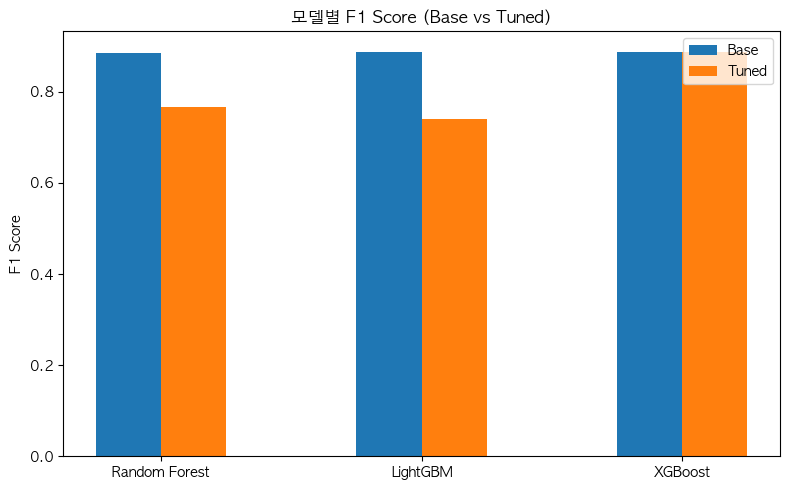

In [ ]:
# Bar Chart 시각화 예시 코드
import matplotlib.pyplot as plt
import numpy as np

models = ['Random Forest', 'LightGBM', 'XGBoost']
base_f1 = [0.8864, 0.8885, 0.8883]
tuned_f1 = [0.7670, 0.7397, 0.8881]

x = np.arange(len(models))
width = 0.25

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, base_f1, width, label='Base')
rects2 = ax.bar(x + width/2, tuned_f1, width, label='Tuned')

ax.set_ylabel('F1 Score')
ax.set_title('모델별 F1 Score (Base vs Tuned)')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.tight_layout()
plt.show()

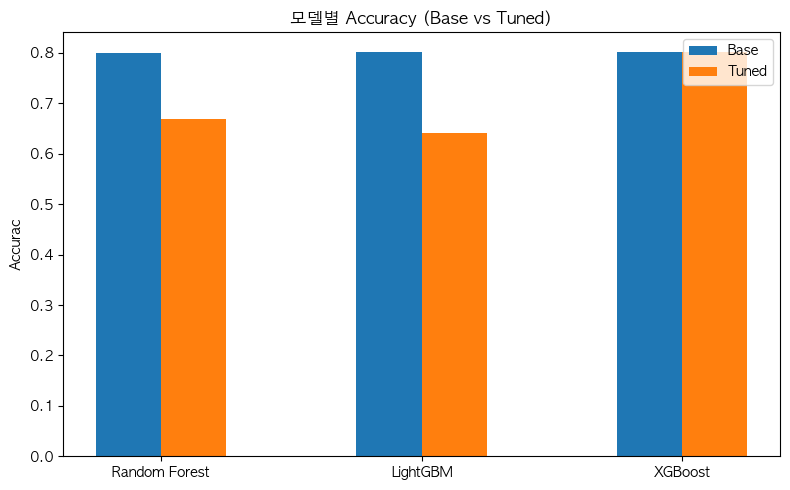

In [ ]:
# Bar Chart 시각화 예시 코드
import matplotlib.pyplot as plt
import numpy as np

models = ['Random Forest', 'LightGBM', 'XGBoost']
base_accr = [0.7994, 0.8017, 0.8017]
tuned_accr = [0.6690, 0.6420, 0.8015]

x = np.arange(len(models))
width = 0.25

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, base_accr, width, label='Base')
rects2 = ax.bar(x + width/2, tuned_accr, width, label='Tuned')

ax.set_ylabel('Accurac')
ax.set_title('모델별 Accuracy (Base vs Tuned)')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.tight_layout()
plt.show()

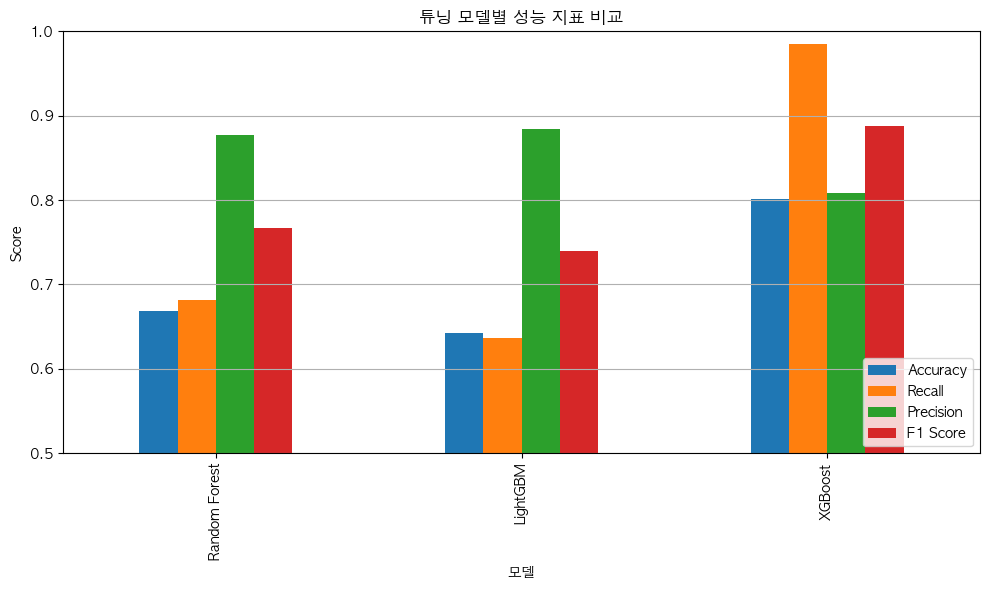

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 성능 데이터
data = {
    '모델': ['Random Forest', 'LightGBM', 'XGBoost'],
    'Accuracy': [0.6690, 0.6420, 0.8015],
    'Recall': [0.6811, 0.6360, 0.9848],
    'Precision': [0.8777, 0.8838, 0.8087],
    'F1 Score': [0.7670, 0.7397, 0.8881]
}

df = pd.DataFrame(data)

# 막대그래프 그리기
df.set_index('모델').plot(kind='bar', figsize=(10,6))
plt.title('튜닝 모델별 성능 지표 비교')
plt.ylabel('Score')
plt.ylim(0.5, 1.0)
plt.legend(loc='lower right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


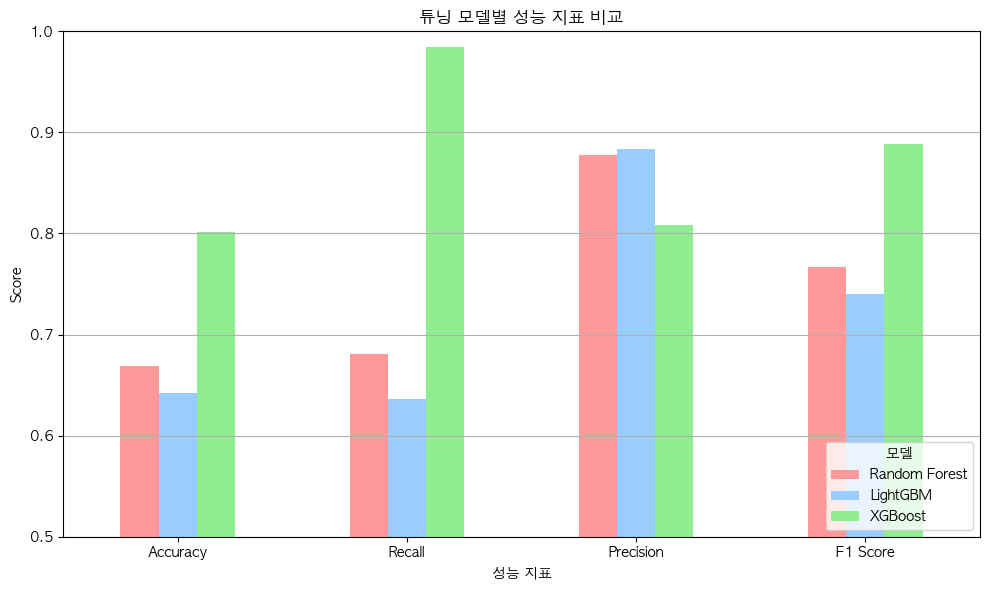

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 성능 데이터
data = {
    '지표': ['Accuracy', 'Recall', 'Precision', 'F1 Score'],
    'Random Forest': [0.6690, 0.6811, 0.8777, 0.7670],
    'LightGBM': [0.6420, 0.6360, 0.8838, 0.7397],
    'XGBoost': [0.8015, 0.9848, 0.8087, 0.8881]
}

# DataFrame 생성
df = pd.DataFrame(data)
df.set_index('지표', inplace=True)

# 막대그래프 그리기
colors = ['#FF9999', '#99CCFF', '#90EE90']  # 각 모델 색상: 빨강, 파랑, 연두

ax = df.plot(kind='bar', figsize=(10, 6), color=colors)

plt.title('튜닝 모델별 성능 지표 비교')
plt.xlabel('성능 지표')
plt.ylabel('Score')
plt.ylim(0.5, 1.0)
plt.xticks(rotation=0)
plt.legend(title='모델', loc='lower right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# 예측 확률
val_probs = xgb_model_grid.predict_proba(X_val)[:, 1]
test_probs = xgb_model_grid.predict_proba(X_test)[:, 1]

# ROC 계산
fpr_val, tpr_val, _ = roc_curve(y_val, val_probs)
fpr_test, tpr_test, _ = roc_curve(y_test, test_probs)

# AUC
val_auc = roc_auc_score(y_val, val_probs)
test_auc = roc_auc_score(y_test, test_probs)

# 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr_val, tpr_val, label=f'Validation AUC = {val_auc:.4f}', color='blue')
plt.plot(fpr_test, tpr_test, label=f'Test AUC = {test_auc:.4f}', color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Random Model')
plt.title('ROC Curve: XGBoost (Validation vs Test)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'xgb_model_grid' is not defined